In [ ]:
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from Align_time import *
from Norm_TF import *

In [5]:
from Visual_YSC import *
from Sim_YSC import *
from Analysis_YSC import *

In [6]:
data_dir = 'data/Yap_Cdx2/'

# Collect and preprocess data

In [7]:
dat = pd.read_csv(data_dir+'all_extracted.csv', index_col = [0,1])

In [8]:
samples = np.array(dat.index.get_level_values(0).unique())

In [9]:
len(samples)

9

In [10]:
# normalize TFs
minmax_tf('Cdx2', dat); mean_tf('Cdx2', dat); zscore_tf('Cdx2', dat)
minmax_tf('Total_Cdx2', dat); mean_tf('Total_Cdx2', dat); zscore_tf('Total_Cdx2', dat)
minmax_tf('Yap', dat); mean_tf('Yap', dat); zscore_tf('Yap', dat)

In [11]:
mins_cdx2 =  dat.groupby(['stack', 'Time'])['Smooth_Total_Cdx2_Minmax'].min()
dat['Smooth_Total_Cdx2_Minmax_corr'] =dat['Smooth_Total_Cdx2_Minmax']-mins_cdx2.loc[dat.reset_index().set_index(['stack', 'Time']).index].values

## Stop at 33 cell stage

In [12]:
dat_full = dat.copy()

In [13]:
thres_times = {}
for st in samples:
    thres_times[st] = dat_full.loc[st].query('Gen == 3').groupby('Branch')['Time'].max().min()
#thres_times
dat = pd.concat([dat_full.loc[st].query('Time <= '+str(thres_times[st]+2)) for st in samples], 
                axis = 0,
               keys = samples).copy()

In [14]:
# normalize time
dat = warp_time(dat)
dat = gen16_time(dat)
dat = gen32_time(dat)

In [15]:
samples[0]

'230503_stack_0'

In [16]:
dat['Gen_time'] = 0
dat['Gen_time'][dat['Gen'] == 2]=dat['Gen16_time'][dat['Gen'] == 2]
dat['Gen_time'][dat['Gen'] == 3]=dat['Gen32_time'][dat['Gen'] == 3]

In [17]:
dat.index.names = ['stack', 'ind']

In [18]:
len(samples)

9

## Stage lengths after subsetting until 33 cell stage

In [19]:
ccl_16_sm = (dat.query('Gen == 2').reset_index()[['stack', 'SmallBranch', 'Time']].drop_duplicates().groupby(['stack', 'SmallBranch', ]).size()/4).reset_index()
ccl_16_sm.columns = ['stack', 'SmallBranch', 'Cell_cycle_length']
ccl_32_sm = (dat.query('Gen == 3').reset_index()[['stack', 'SmallBranch', 'Time']].drop_duplicates().groupby(['stack', 'SmallBranch',]).size()/4).reset_index()
ccl_32_sm.columns = ['stack', 'SmallBranch','Cell_cycle_length']

Text(0.5, 0.98, 'YAP-CDX2')

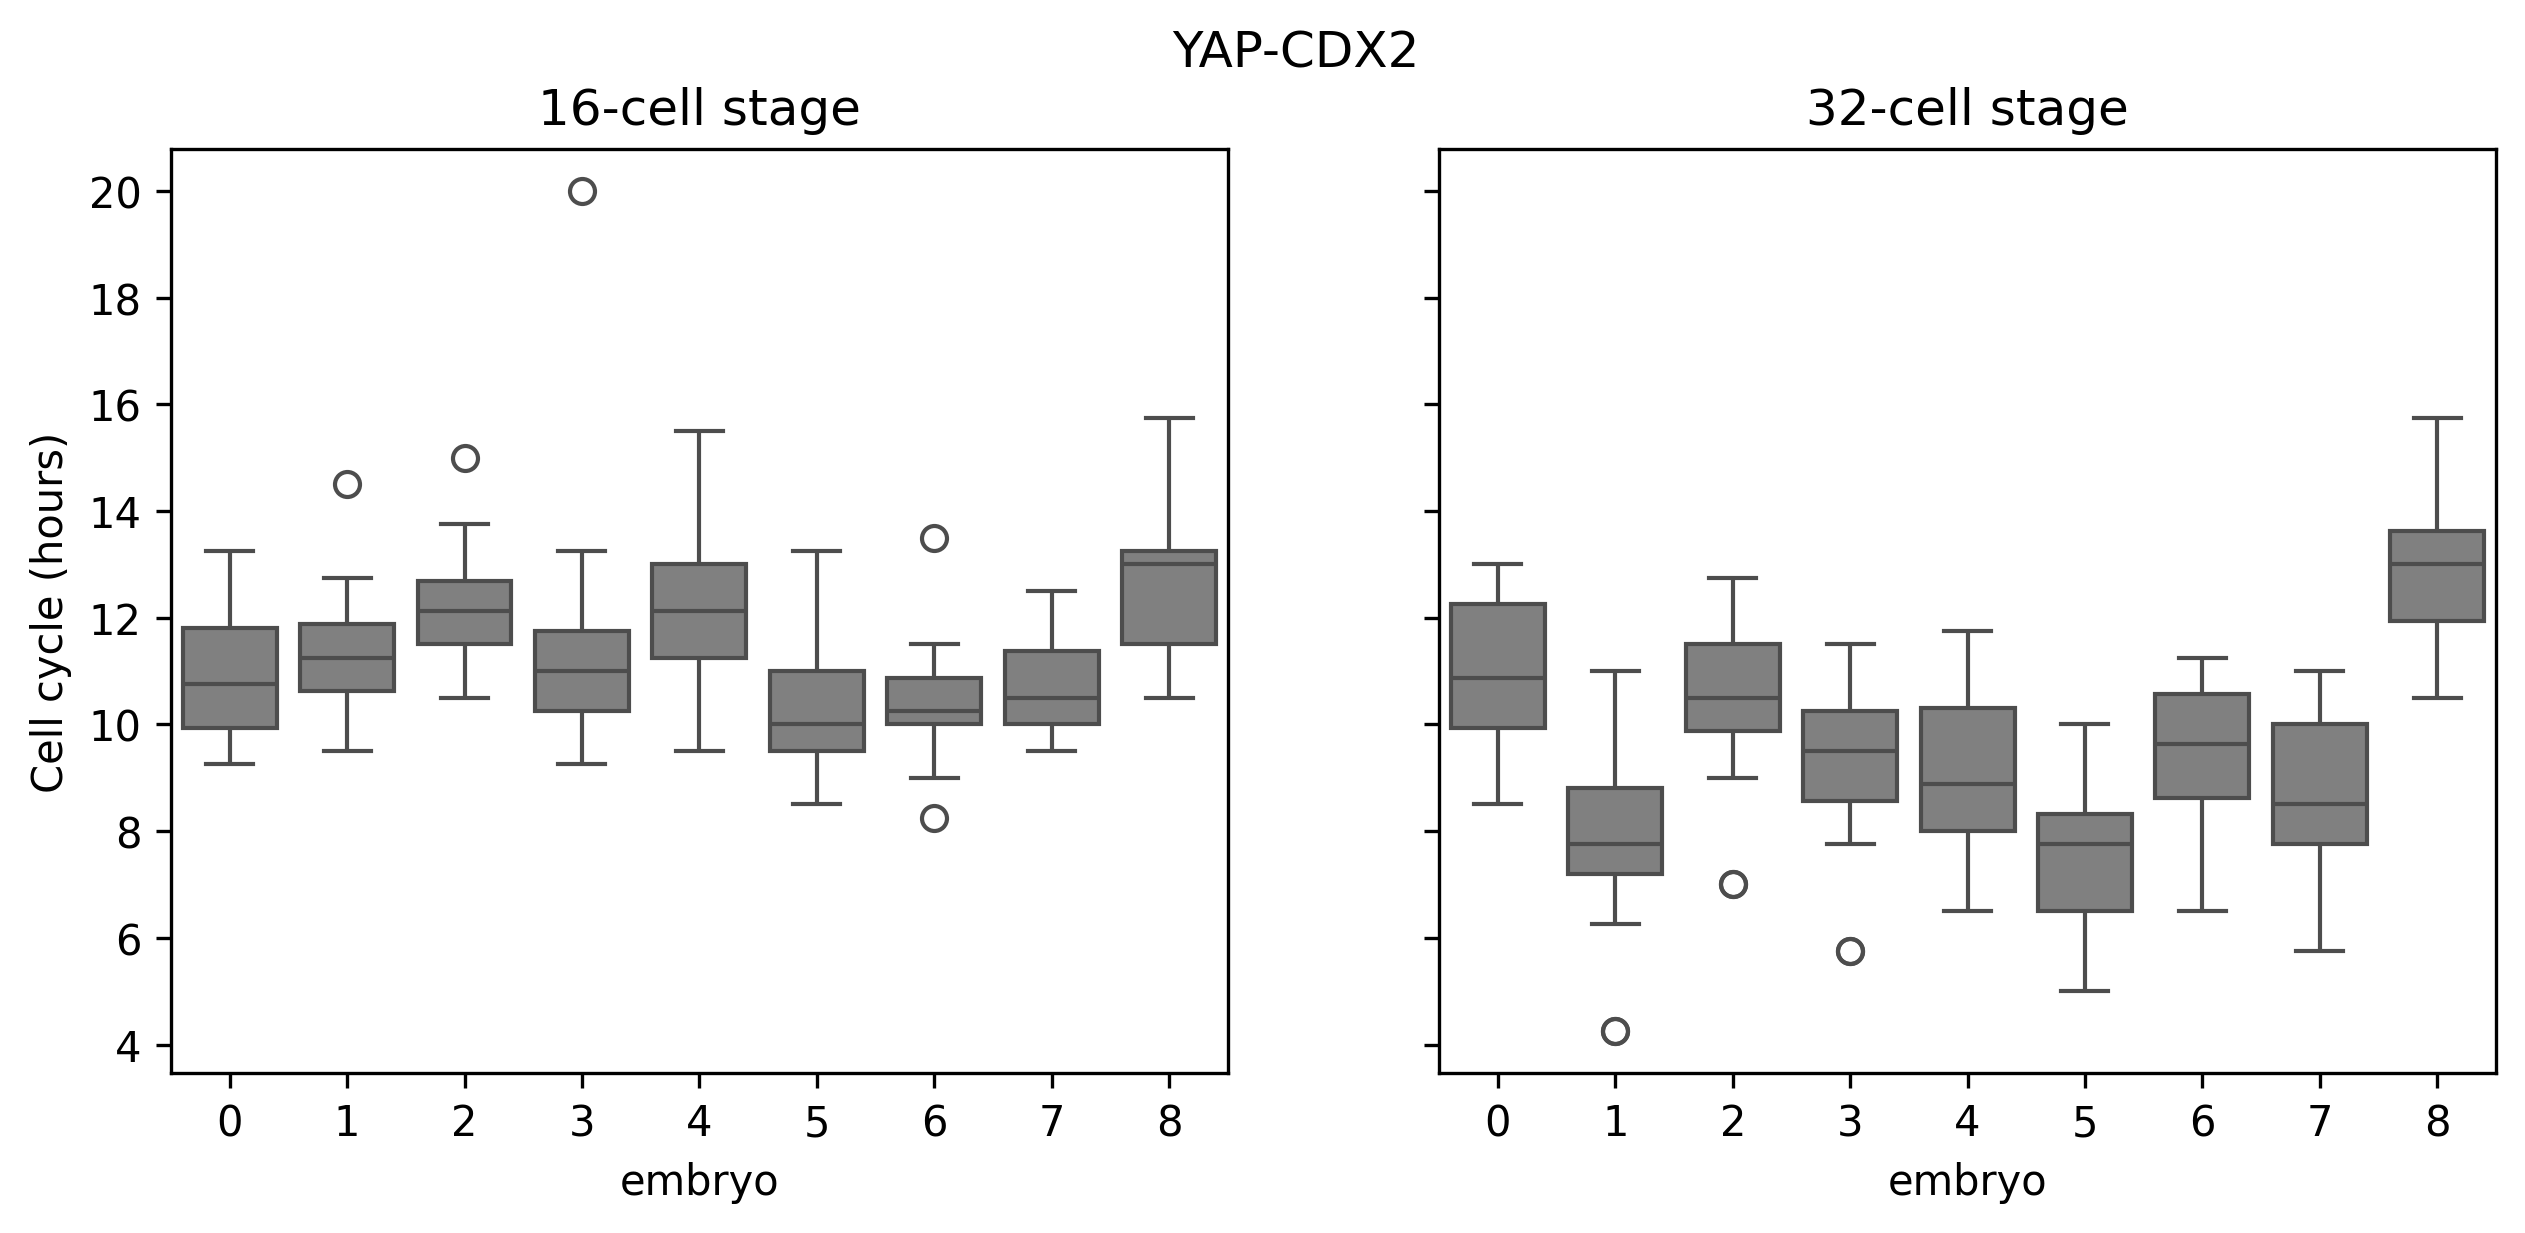

In [20]:
fig, axes = plt.subplots(1,2, dpi = 300, figsize = (10,4), sharey = True)
ax = axes[0]
sns.boxplot(ccl_16_sm, x = 'stack', y = 'Cell_cycle_length', ax = ax, color = 'grey')
ax.set_xticks(rotation = 0, ticks = range(9),
               labels = [str(i) for i in range(9)])
ax.set_xlabel('embryo')
ax.set_ylabel('Cell cycle (hours)')
ax.set_title('16-cell stage')
ax = axes[1]
sns.boxplot(ccl_32_sm, x = 'stack', y = 'Cell_cycle_length', ax = ax, color = 'grey')
ax.set_xticks(rotation = 0, ticks = range(9),
               labels = [str(i) for i in range(9)])
ax.set_xlabel('embryo')
ax.set_title('32-cell stage')
plt.suptitle('YAP-CDX2')
# plt.savefig('figures_for_YSC_Bayesian_paper/S2A_1.png', dpi = 500)
# plt.savefig('figures_for_YSC_Bayesian_paper/S2A_1.svg', dpi = 500)

## Define unique branches

In [21]:
dat['Cycle_stage'] = ['Early' if x-int(x)<0.5 else 'Late' for x in dat['Warped_time']]
simp_dat = dat.set_index(['Branch', 'SmallBranch', 'Cycle_stage'], append = True).query('Gen_time>=8')._get_numeric_data().groupby(['stack', 'Gen', 'Cycle_stage', 'Branch']).mean().drop_duplicates()

In [22]:
simp_dat_final = dat.sort_values('Time').set_index(['Gen', 'Branch', 'SmallBranch', 'Cycle_stage'], append = True).query('Gen_time>=8')._get_numeric_data().droplevel(['ind', 'SmallBranch']).groupby(['stack', 'Gen', 'Cycle_stage', 'Branch']).tail(1)#.drop_duplicates()



In [23]:
with_sm = dat.set_index(['Branch', 'SmallBranch'], append = True).query('Gen == 3')._get_numeric_data().groupby(['stack', 'Gen', 'Branch', 'SmallBranch']).mean()
with_sm = with_sm.reset_index('Branch')
with_sm = with_sm[~with_sm.index.duplicated(keep='first')]
with_sm = with_sm.reset_index('stack')
branches_to_keep = list(zip(with_sm['stack'], with_sm['Branch']))
simp_dat_short = simp_dat.loc[[x in branches_to_keep for x in list(zip(simp_dat.reset_index()['stack'], simp_dat.reset_index()['Branch']))],:]

In [24]:
dat_copy = dat.copy()
dat_copy = dat_copy.reset_index().set_index(['stack', 'Branch'])
dat_short = dat_copy.loc[dat_copy.index.isin(branches_to_keep),:]

In [25]:
wp_dat_short = dat_short.set_index(['Gen', 'SmallBranch', 'Cycle_stage'], append = True)._get_numeric_data().groupby(['stack', 'Gen', 'Branch', 'SmallBranch', 'Cycle_stage', 'Warped_time']).mean().reset_index('Warped_time')





In [26]:
simp_dat_final_short = wp_dat_short.sort_values('Warped_time').reset_index().set_index(['stack','Gen', 'Branch', 'SmallBranch', 'Cycle_stage'], append = True).query('Gen_time>=8')._get_numeric_data().droplevel(['SmallBranch']).groupby(['stack', 'Gen', 'Cycle_stage', 'Branch']).tail(1).droplevel(0)#.drop_duplicates()



#simp_dat_final.loc[[x in branches_to_keep for x in list(zip(simp_dat_final.reset_index()['stack'], simp_dat_final.reset_index()['Branch']))],:]




In [27]:
wp_dat_short = dat_short._get_numeric_data().groupby(['stack', 'Branch', 'Warped_time']).mean().reset_index('Warped_time')

In [28]:
beg_16 = wp_dat_short.query('Warped_time > 1.01 and Warped_time <1.09')
mid_16 = wp_dat_short.query('Warped_time > 1.46 and Warped_time <1.54')
end_16 = wp_dat_short.query('Warped_time > 1.91 and Warped_time <1.99')
mid_32 = wp_dat_short.query('Warped_time > 2.46 and Warped_time <2.54')
end_32 = wp_dat_short.query('Warped_time > 2.91 and Warped_time <2.99')

In [29]:
tv_16 = (end_16-beg_16)['Smooth_Total_Cdx2_Minmax_corr']
tv_32_early = (mid_32-beg_16)['Smooth_Total_Cdx2_Minmax_corr']
tv_32_late = (end_32-beg_16)['Smooth_Total_Cdx2_Minmax_corr']

# Classification

## Cdx2

In [30]:
from sklearn.mixture import GaussianMixture as GM

In [31]:
np.random.seed(2)
km = GM(3)
cdx2_16_all = simp_dat_final_short['Smooth_Total_Cdx2_Minmax_corr'].droplevel(['Gen', 'Cycle_stage'])
vls = cdx2_16_all.values.reshape(-1,1)
km.fit(vls)
lbs = km.predict(vls)
centers = km.means_#cluster_centers_
args = np.argsort(np.argsort(np.ravel(centers)))
lbs = pd.Series([args[lb] for lb in lbs],
                index = cdx2_16_all.index).astype(str)
lbs[lbs == '2'] = '1'


In [32]:
thres = (np.max(cdx2_16_all.values[lbs == '0'])+np.min(cdx2_16_all.values[lbs == '1']))/2

In [33]:
thres

0.08847666576902619

In [34]:
np.random.seed(2)
km = GM(3)
cdx2_16_late = simp_dat_final_short.query('Gen == 2').query('Cycle_stage == "Late"')['Smooth_Total_Cdx2_Minmax_corr'].droplevel(['Gen', 'Cycle_stage'])
vls = cdx2_16_late.values.reshape(-1,1)
lbs = pd.Series((np.ravel(vls)>thres).astype(int),
                index = cdx2_16_late.index).astype(str)
dat_short['16cs_CDX2_late_status'] = lbs.loc[dat_short.reset_index().set_index(['stack', 'Branch']).index]

In [35]:
np.random.seed(2)
dat_short['32cs_CDX2_early_status'] = np.nan
cdx2_32_early = simp_dat_final_short.query('Gen == 3').query('Cycle_stage == "Early"')['Smooth_Total_Cdx2_Minmax_corr'].droplevel(['Gen', 'Cycle_stage'])
vls = cdx2_32_early.values.reshape(-1,1)
lbs = pd.Series((np.ravel(vls)>thres).astype(int),
                index = cdx2_32_early.index).astype(str)
dat_short['32cs_CDX2_early_status'] = lbs.loc[dat_short.reset_index().set_index(['stack', 'Branch']).index]

In [36]:
np.random.seed(2)
dat_short['32cs_CDX2_late_status'] = np.nan
km = GM(3)
cdx2_32_late = simp_dat_final_short.query('Gen == 3').query('Cycle_stage == "Late"')['Smooth_Total_Cdx2_Minmax_corr'].droplevel(['Gen', 'Cycle_stage'])
vls = cdx2_32_late.values.reshape(-1,1)
lbs = pd.Series((np.ravel(vls)>thres).astype(int),
                index = cdx2_32_late.index).astype(str)
dat_short['32cs_CDX2_late_status'] = lbs.loc[dat_short.reset_index().set_index(['stack', 'Branch']).index]

In [37]:
dat_short['8cs_CDX2_status'] = '0'
dat_short['16cs_CDX2_early_status'] = '0'

## YAP

In [38]:
thres_yap_early = -0.586417661470855
thres_yap = -0.8169255065580239
thres_yap_32_early = -0.6071130370039592
thres_yap_32_late = -0.5796090356007886

In [39]:
yap_16_early = simp_dat_short.query('Gen == 2').query('Cycle_stage == "Early"')['Smooth_Yap_zscore']
# sns.distplot(yap_16_early, bins = 30)
# plt.axvline(thres_yap_early)
# plt.title('Early 16 cell stage')

In [40]:
yap_16_late = simp_dat_short.query('Gen == 2').query('Cycle_stage == "Late"')['Smooth_Yap_zscore']
# sns.distplot(yap_16_late, bins = 30)
# plt.axvline(thres_yap)
# plt.title('Late 16 cell stage')

In [41]:
yap_32_early = simp_dat_short.query('Gen == 3').query('Cycle_stage == "Early"')['Smooth_Yap_zscore']
# sns.distplot(yap_32_early, bins = 30)
# plt.axvline(thres_yap_32_early, color = 'black', linestyle = '--')
# plt.title('Early 32 cell stage')

In [42]:
yap_32_late = simp_dat_short.query('Gen == 3').query('Cycle_stage == "Late"')['Smooth_Yap_zscore']
# sns.distplot(yap_32_late, bins = 30)
# plt.axvline(thres_yap_32_late, color = 'black', linestyle = '--')
# plt.title('Late 32 cell stage')

In [43]:
high_16cs_yap = yap_16_early.loc[yap_16_early>thres_yap_early,:].index.droplevel(['Gen', 'Cycle_stage'])
low_16cs_yap = yap_16_early.loc[yap_16_early<=thres_yap_early,:].index.droplevel(['Gen', 'Cycle_stage'])
allbr = dat_short.reset_index().set_index(['stack', 'Branch']).index
sts = []
for x in allbr:
    if x in high_16cs_yap:
        sts.append('High')
    elif x in low_16cs_yap:
        sts.append('Low')
    else:
        sts.append(np.nan)
dat_short['16cs_Yap_early_status'] = sts

In [44]:
high_16cs_yap = yap_16_late.loc[yap_16_late>thres_yap,:].index.droplevel(['Gen', 'Cycle_stage'])
low_16cs_yap = yap_16_late.loc[yap_16_late<=thres_yap,:].index.droplevel(['Gen', 'Cycle_stage'])
allbr = dat_short.reset_index().set_index(['stack', 'Branch']).index
sts = []
for x in allbr:
    if x in high_16cs_yap:
        sts.append('High')
    elif x in low_16cs_yap:
        sts.append('Low')
    else:
        sts.append(np.nan)
dat_short['16cs_Yap_status'] = sts

In [45]:
high_32cs_yap = yap_32_early.loc[yap_32_early>thres_yap_32_early,:].index.droplevel(['Gen', 'Cycle_stage'])
low_32cs_yap = yap_32_early.loc[yap_32_early<=thres_yap_32_early,:].index.droplevel(['Gen', 'Cycle_stage'])
allbr = dat_short.reset_index().set_index(['stack', 'Branch']).index
sts = []
for x in allbr:
    if x in high_32cs_yap:
        sts.append('High')
    elif x in low_32cs_yap:
        sts.append('Low')
    else:
        sts.append(np.nan)
dat_short['32cs_Yap_early_status'] = sts

In [46]:
high_32cs_yap = yap_32_late.loc[yap_32_late>thres_yap_32_late,:].index.droplevel(['Gen', 'Cycle_stage'])
low_32cs_yap = yap_32_late.loc[yap_32_late<=thres_yap_32_late,:].index.droplevel(['Gen', 'Cycle_stage'])
allbr = dat_short.reset_index().set_index(['stack', 'Branch']).index
sts = []
for x in allbr:
    if x in high_32cs_yap:
        sts.append('High')
    elif x in low_32cs_yap:
        sts.append('Low')
    else:
        sts.append(np.nan)
dat_short['32cs_Yap_late_status'] = sts

In [47]:
dat_short['8cs_Yap_status'] = 'High'


In [48]:
simp_dat_info = dat_short.reset_index().set_index(['stack', 'Gen', 'Cycle_stage', 'Branch']).query('Gen_time>=8').select_dtypes(exclude='number').iloc[:, 1:].reset_index().drop_duplicates().set_index(['stack', 'Gen', 'Cycle_stage', 'Branch'])




simp_dat_info_short = simp_dat_info.query('Gen == 2').query('Cycle_stage == "Late"')
simp_dat_info_short = simp_dat_info_short.loc[[x in branches_to_keep for x in list(zip(simp_dat_info_short.reset_index()['stack'], simp_dat_info_short.reset_index()['Branch']))],:]



## Example

In [49]:
yap_stats = simp_dat_info_short[['8cs_Yap_status','16cs_Yap_early_status','16cs_Yap_status', '32cs_Yap_early_status', '32cs_Yap_late_status']]
def map_high_low(x):
    if x == 'High':
        return 1
    else:
        return 0
yap_stats = yap_stats.applymap(map_high_low)
cdx2_stats = simp_dat_info_short[['8cs_CDX2_status', '16cs_CDX2_early_status','16cs_CDX2_late_status', '32cs_CDX2_early_status', '32cs_CDX2_late_status']]
#rea_stats = rea_stats.applymap(map_high_low)

In [50]:
def map_to_fc(s_expr):
    if s_expr == (0,0,0,0,0):
        return '$C^-$'
    elif s_expr[2] == 1:
        return '$C^+_{16L}$'
    elif s_expr[3] == 1:
        return '$C^+_{32E}$'
    elif s_expr[4] == 1:
        return '$C^+_{32L}$'

fs = pd.Series([tuple(x) for x in cdx2_stats.values.astype(int)]).map(map_to_fc)
fs = pd.Series(fs.values, index = cdx2_stats.index).droplevel([1,2])
dat_short['Fate_stage'] = fs.loc[dat_short.index]

In [51]:
wp_dat_short = dat_short.set_index('Fate_stage', append = True)._get_numeric_data().groupby(['stack', 'Branch', 'Warped_time', 'Fate_stage']).mean().reset_index('Warped_time')



In [52]:
st = samples[0]

In [53]:
#ind_palette = ['dodgerblue', 'magenta','red', 'darkgray']

ind_palette = sns.color_palette('magma', 4)
#cols = ['#1E90FF', '#FF00FF','#FF0000', 'darkgray']
cols = ['dodgerblue', 'magenta', 'red', 'darkgray']
ind_palette = dict(zip([ '$C^+_{16L}$','$C^+_{32E}$','$C^+_{32L}$', '$C^-$'],cols))


Text(0.5, 0, 'Cell stage')

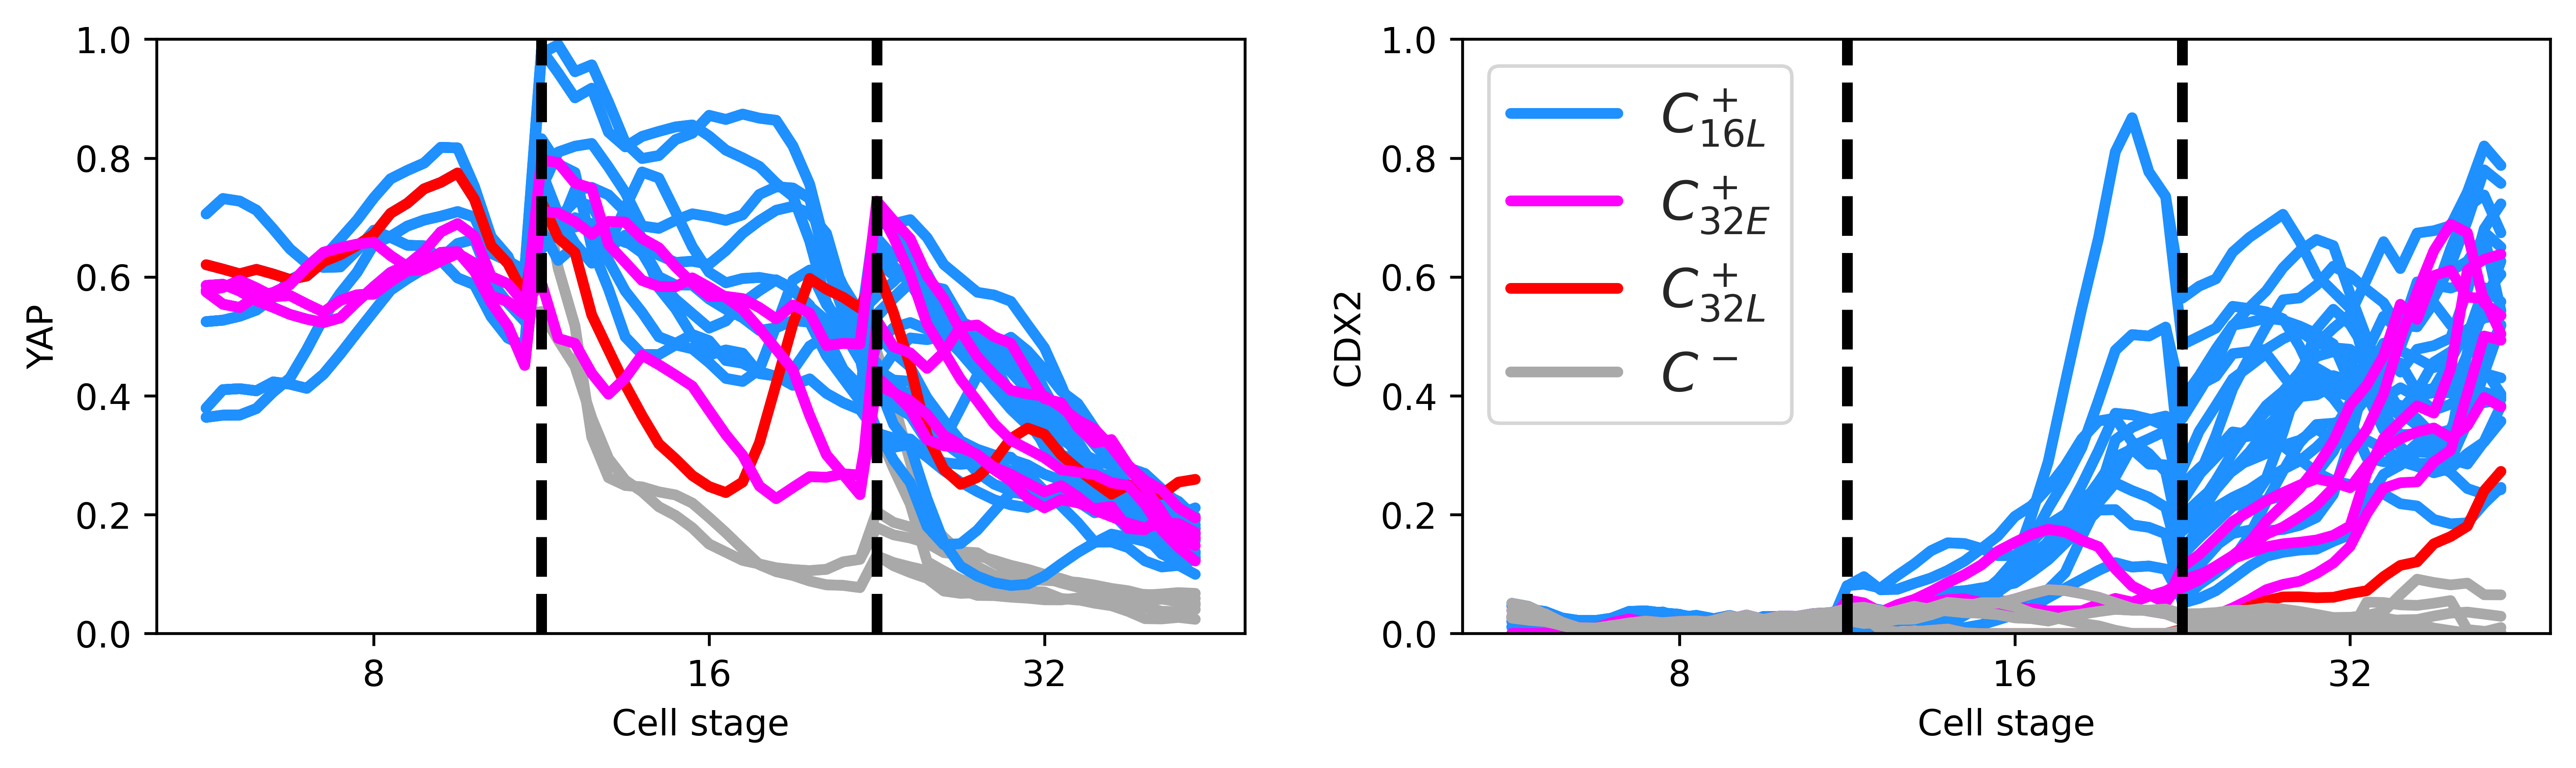

In [54]:
fig, axes = plt.subplots(1,2,dpi = 600, figsize = (12,3), sharey = False)
ax = axes[0]
sns.set(palette = 'nipy_spectral', style = 'white', font_scale = 1.5)
sns.lineplot(wp_dat_short.query('Gen<=3').loc[st], ax = ax,
             estimator = None, lw = 3,
             units = 'Branch', 
             y = 'Smooth_Yap_Minmax',
             x = 'Warped_time', hue= 'Fate_stage', legend = False,
             hue_order = ['$C^-$', '$C^+_{16L}$','$C^+_{32L}$', '$C^+_{32E}$', ],
                                palette = ind_palette)#[ 'darkgray', 'dodgerblue','red', 'magenta', ],)
ax.axvline(1, linestyle = '--', c = 'black', lw = 3)
ax.axvline(2, linestyle = '--', c = 'black', lw = 3)
ax.set_ylabel('YAP')
ax.set_xlabel('')
#ax.legend(title = '', fontsize = 15)
ax.legend = []
ax.set_xticks([0.5, 1.5, 2.5], ['8', '16', '32'])
ax.set_xlabel('Cell stage')
ax.set_ylim(0,1)
ax = axes[1]
sns.set(palette = 'nipy_spectral', style = 'white', font_scale = 1.5)
sns.lineplot(wp_dat_short.query('Gen<=3').loc[st], ax = ax,
             estimator = None, lw = 3,
             units = 'Branch', 
             y = 'Smooth_Total_Cdx2_Minmax_corr',
             x = 'Warped_time', hue= 'Fate_stage', 
             legend = True, hue_order = [ '$C^+_{16L}$','$C^+_{32E}$','$C^+_{32L}$', '$C^-$'],
                                palette = ind_palette)#['dodgerblue', 'magenta','red', 'darkgray'],)
ax.axvline(1, linestyle = '--', c = 'black', lw = 3)
ax.axvline(2, linestyle = '--', c = 'black', lw = 3)
ax.set_ylabel('CDX2')
ax.set_xlabel('')
ax.legend(title = '', fontsize = 15)
ax.set_xticks([0.5, 1.5, 2.5], ['8', '16', '32'])
ax.set_ylim(0,1)
ax.set_xlabel('Cell stage')
# plt.savefig('figures_for_YSC_Bayesian_paper/2B.svg')
# plt.savefig('figures_for_YSC_Bayesian_paper/2B.png')

## Another example

In [55]:
high_yap = [np.sum(x != [1]*5)==0 for x in yap_stats.values]
c16 = [np.sum(x != [0,0,1,1,1])==0 for x in cdx2_stats.astype(int).values]
c32e = [np.sum(x != [0,0,0,1,1])==0 for x in cdx2_stats.astype(int).values]
bth_c16 = np.array(high_yap)*np.array(c16)
bth_c32e = np.array(high_yap)*np.array(c32e)

In [56]:
yap_trans = [yap_stats.loc[bth_c16,:].droplevel(['Gen', 'Cycle_stage']).index[3]]
yap_trans+= [yap_stats.loc[bth_c32e,:].droplevel(['Gen', 'Cycle_stage']).index[3]]



In [59]:
to_cons = pd.concat([wp_dat_short.loc[x] for x in yap_trans],
         keys = yap_trans)
to_cons.index.names = ['stack', 'Branch', 'Fate_stage']

Text(0.5, 0, 'Cell stage')

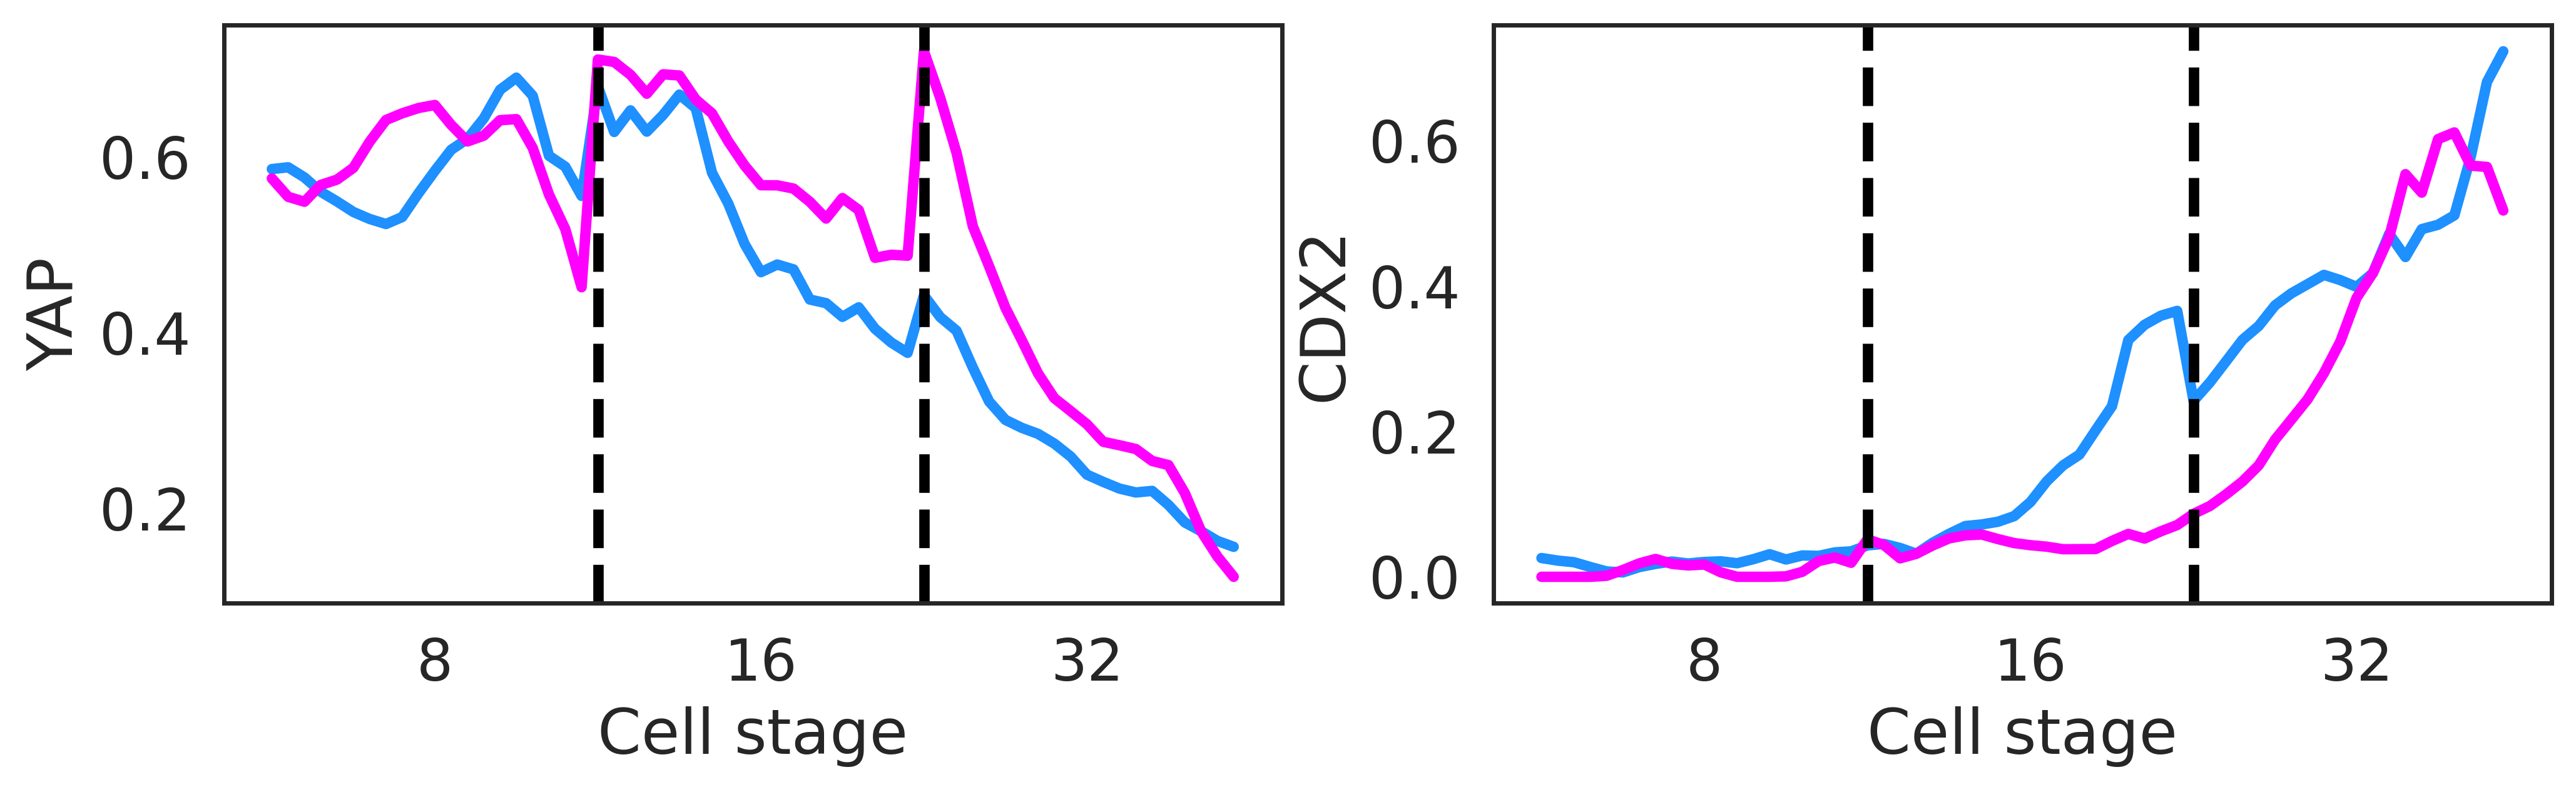

In [60]:
fig, axes = plt.subplots(1,2, dpi = 400, figsize = (12,3))
ax = axes[0]

sns.lineplot(to_cons.query('Gen<=3').reset_index(), estimator = None, lw = 3,
             units = 'Branch', y = 'Smooth_Yap_Minmax',
             x = 'Warped_time', hue= 'Fate_stage', legend = False,
             hue_order = [ '$C^+_{16L}$','$C^+_{32E}$', '$C^-$','$C^+_{32L}$'],
                                palette = ['dodgerblue', 'magenta',  'darkgray', 'red',],
            ax = ax)
ax.axvline(1, linestyle = '--', c = 'black', lw = 3)
ax.axvline(2, linestyle = '--', c = 'black', lw = 3)
ax.set_ylabel('YAP')
ax.set_xlabel('')
#plt.legend(title = '', fontsize = 15)
ax.set_xticks([0.5, 1.5, 2.5], ['8', '16', '32'])
ax.set_xlabel('Cell stage')

ax = axes[1]

sns.lineplot(to_cons.query('Gen<=3').reset_index(), estimator = None, lw = 3,
             units = 'Branch', y = 'Smooth_Total_Cdx2_Minmax_corr',
             x = 'Warped_time', hue= 'Fate_stage', legend = False,
             hue_order = [ '$C^+_{16L}$','$C^+_{32E}$', '$C^-$','$C^+_{32L}$'],
                                palette = ['dodgerblue', 'magenta',  'darkgray', 'red',],
            ax = ax)

ax.axvline(1, linestyle = '--', c = 'black', lw = 3)
ax.axvline(2, linestyle = '--', c = 'black', lw = 3)
ax.set_ylabel('CDX2')
ax.set_xlabel('')
#plt.legend(title = '', fontsize = 15)
ax.set_xticks([0.5, 1.5, 2.5], ['8', '16', '32'])
ax.set_xlabel('Cell stage')

#plt.tight_layout()
# plt.savefig('figures_for_YSC_Bayesian_paper/S3C.png')
# plt.savefig('figures_for_YSC_Bayesian_paper/S3C.svg')

# Binarized pairwise data

In [61]:
d0 = dat_short.query('Gen == 1').groupby(['stack', 'Branch'])['Smooth_Total_Cdx2_Minmax_corr'].mean()
d1 = simp_dat_final_short.query('Gen == 2').query('Cycle_stage == "Early"').groupby(['stack', 'Branch'])['Smooth_Total_Cdx2_Minmax_corr'].mean()
d2 = simp_dat_final_short.query('Gen == 2').query('Cycle_stage == "Late"').groupby(['stack', 'Branch'])['Smooth_Total_Cdx2_Minmax_corr'].mean()
d3 = simp_dat_final_short.query('Gen == 3').query('Cycle_stage == "Early"').groupby(['stack', 'Branch'])['Smooth_Total_Cdx2_Minmax_corr'].mean()
d4 = simp_dat_final_short.query('Gen == 3').query('Cycle_stage == "Late"').groupby(['stack', 'Branch'])['Smooth_Total_Cdx2_Minmax_corr'].mean()

In [62]:
rs2 = pd.concat([d0,d1, d2, d3, d4], axis= 1)
rs2.columns = ['0=8','1=16E', '2=16L', '3=32E', '4=32L']
rs = cdx2_stats.droplevel([1,2]).copy()
rs.columns = rs2.columns
inter = rs2.stack().index.intersection(rs.stack().index)
all_rs = rs.stack().loc[inter].reset_index()
all_rs.columns = ['stack', 'Branch', 'Stage', 'Value']
all_rs['CDX2'] = rs2.stack().loc[inter].values
#all_rs['Pos'] = ['Outer' if x else 'Inner' for x in all_rs['Pos']]

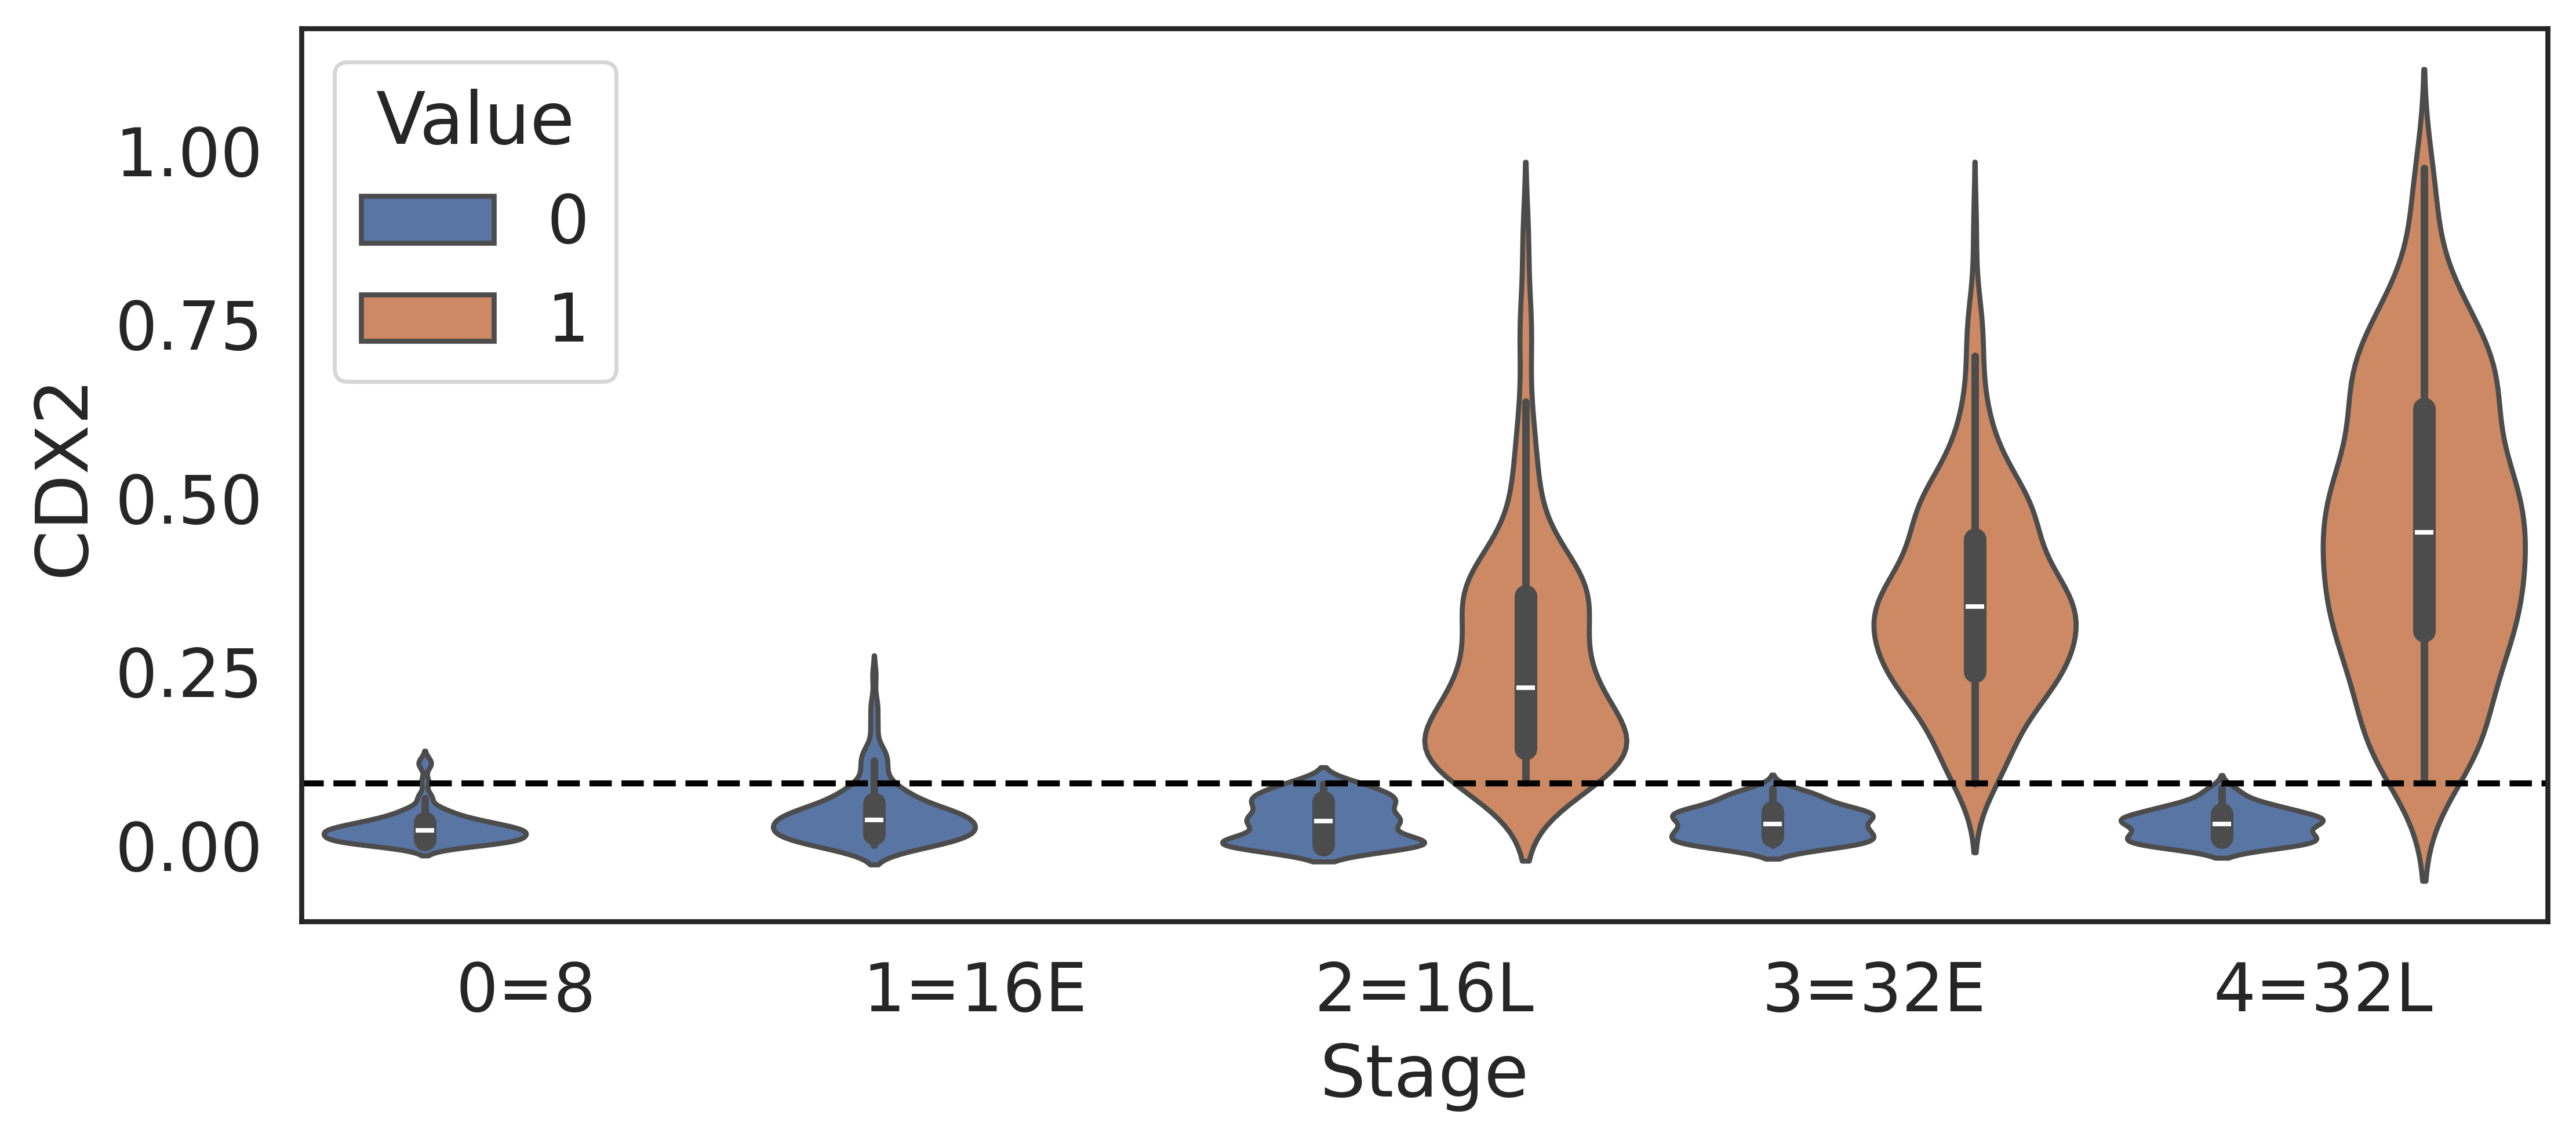

In [63]:
sns.set(style = 'white', font_scale = 1.5)
plt.figure(dpi = 500, figsize = (10,4))
sns.violinplot(data = all_rs, x = 'Stage', y = 'CDX2', 
               hue = 'Value', hue_order = ['0', '1'], 
              #palette = ['limegreen', 'darkmagenta'], 
               density_norm = 'width',
               width = 0.9)
ax = plt.gca()
ax.axhline(thres, c = 'black', linestyle = '--')
handles, previous_labels = ax.get_legend_handles_labels()

## Example

In [64]:
st = samples[0]

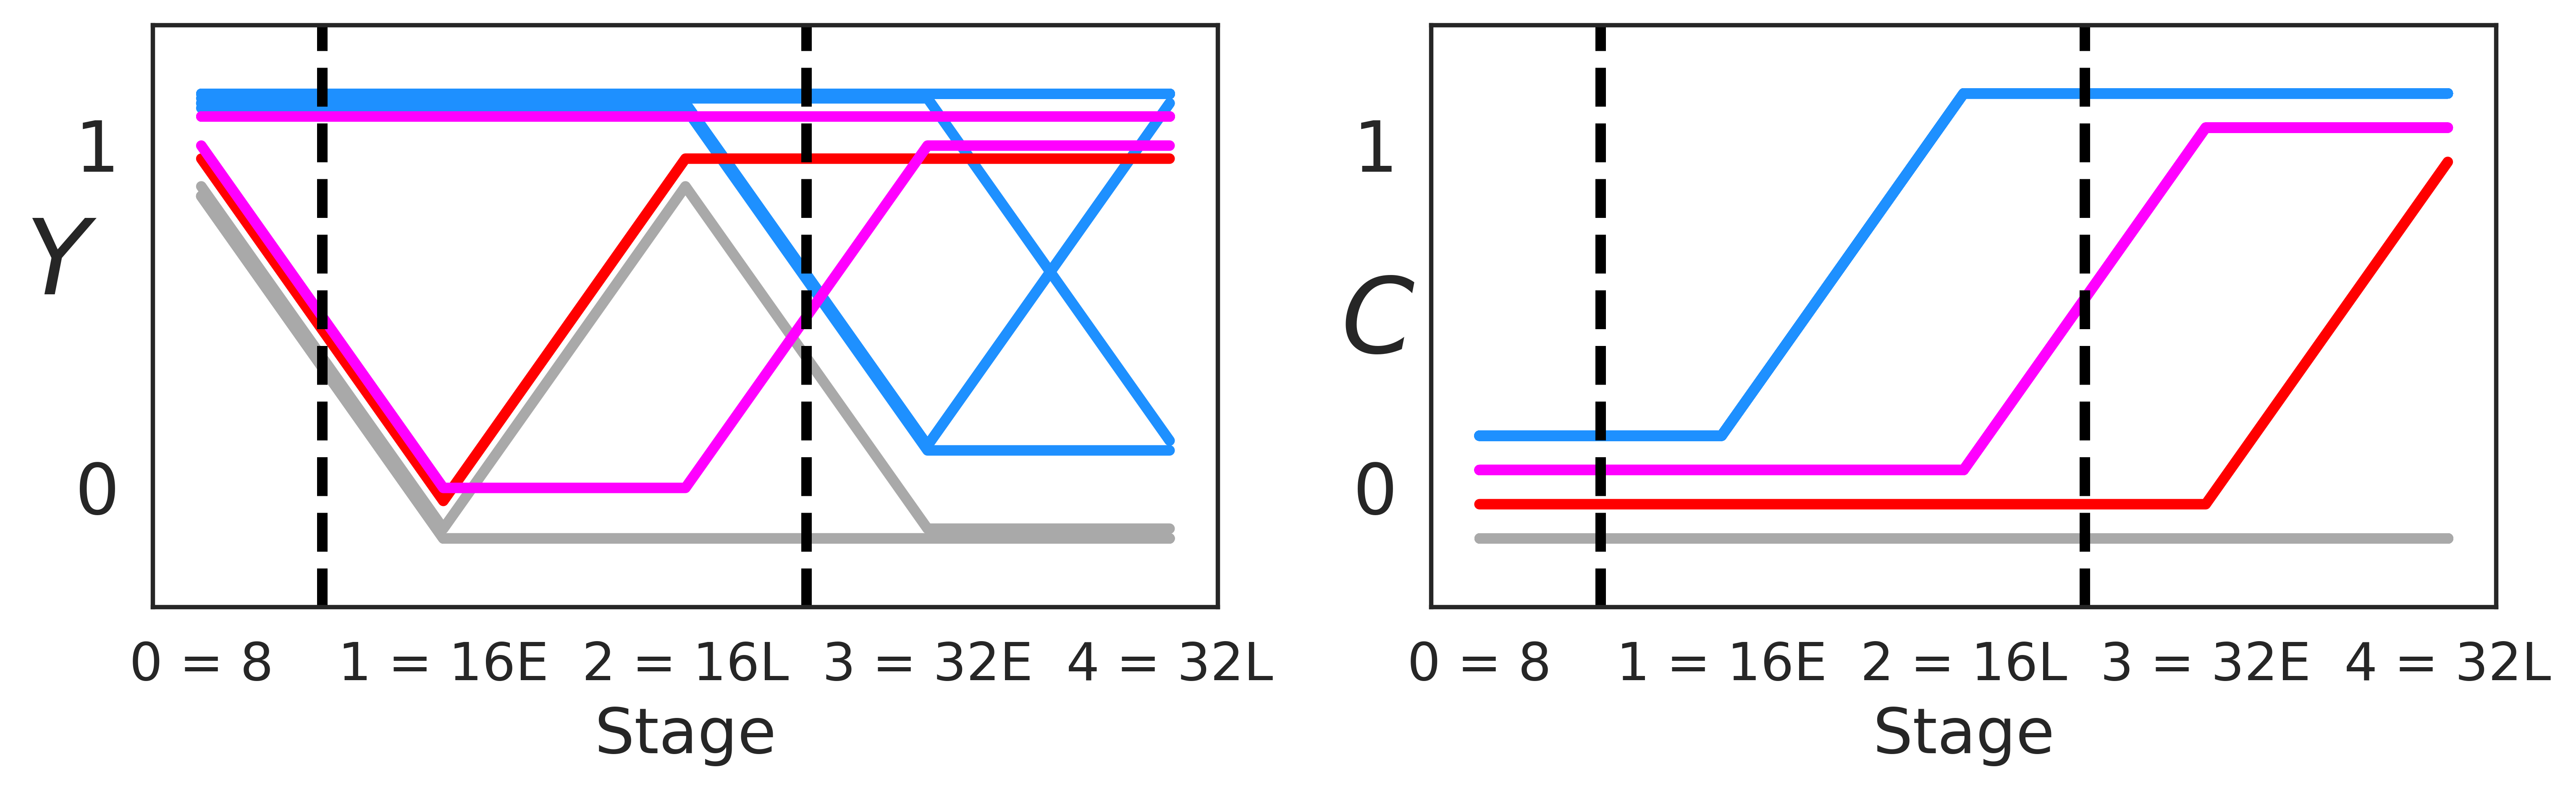

In [65]:
fig, axes = plt.subplots(1,2,dpi = 600, figsize = (12,3), sharey =False)
ax = axes[1]
rel = cdx2_stats.query('stack == "'+st+'"').droplevel([1,2]).copy()
rel['Fate_stage'] = fs.loc[rel.index]
#print(pd.DataFrame(rel.value_counts().sort_index()))
rel = rel.set_index('Fate_stage', append = True).astype(int)
unique_fates = np.array([ '$C^-$',  '$C^+_{32L}$','$C^+_{32E}$', '$C^+_{16L}$', ])
jitters = np.linspace(0., 0.2, 4)
ys = pd.Series([tuple(x) for x in cdx2_stats.query('stack == "'+st+'"').values.astype(int)])
ys_cl = pd.factorize(ys, sort = True)[0]
ys_un = np.array(range(len(pd.factorize(ys, sort = True)[1])))
jitters2 = np.linspace(0., 0.1, len(ys_un))

for i in range(rel.shape[0]):
    jitter = np.zeros(rel.shape[0])
    jitter[i] = jitters[np.where(unique_fates == fs[i])[0]]
    jitter[i] += jitters2[np.where(ys_un == ys_cl[i])[0]]
    rel +=jitter.reshape(-1,1)
rel = rel.stack().reset_index()
rel.columns = ['stack', 'Branch', 'Fate_stage', 'Stage', 'CDX2 class']
#rel['Status_num'] = pd.factorize(rel['Sox2 status'])[0]
sns.lineplot(rel, x = 'Stage', 
                  y = 'CDX2 class', 
                  units = 'Branch', 
                  estimator = None,
                  lw = 3,legend = None,
                  hue = 'Fate_stage', alpha = 1, hue_order = [ '$C^-$','$C^+_{16L}$','$C^+_{32L}$','$C^+_{32E}$'],
                 palette = ['darkgray','dodgerblue','red',  'magenta'], ax = ax)
ax.set_xticks(ticks = ax.get_xticks(), 
           labels = ['0 = 8', '1 = 16E', '2 = 16L', '3 = 32E', '4 = 32L'],
          fontsize = 15)
ax.axvline(0.5, linestyle = '--', c = 'black', lw = 3)
ax.axvline(2.5, linestyle = '--', c = 'black', lw = 3)
ax.set_yticks(ticks = [0.15,1.15],
           labels = ['0', '1'], fontsize = 20)#,
           #horizontalalignment='center')
ax.set_ylabel('$C$', rotation = 0, fontsize = 30)
ax.set_ylim(-0.2, 1.5)
ax = plt.gca()
ax.yaxis.set_label_coords(-0.05,0.4)

ax = axes[0]
rel = yap_stats.query('stack == "'+st+'"').droplevel([1,2]).copy()
rel['Fate_stage'] = fs.loc[rel.index]
#print(pd.DataFrame(rel.value_counts().sort_index()))
rel = rel.set_index('Fate_stage', append = True).astype(int)
unique_fates = np.array([ '$C^+_{16L}$','$C^+_{32E}$',  '$C^+_{32L}$','$C^-$', ])[::-1]
jitters = np.linspace(0., 0.2, 4)
ys = pd.Series([tuple(x) for x in yap_stats.query('stack == "'+st+'"').values.astype(int)])
ys_cl = pd.factorize(ys, sort = True)[0]
ys_un = np.array(range(len(pd.factorize(ys, sort = True)[1])))
jitters2 = np.linspace(0., 0.1, len(ys_un))
for i in range(rel.shape[0]):
    jitter = np.zeros(rel.shape[0])
    jitter[i] = jitters[np.where(unique_fates == fs[i])[0]]
    jitter[i] += jitters2[np.where(ys_un == ys_cl[i])[0]]
    rel +=jitter.reshape(-1,1)
rel = rel.stack().reset_index()
rel.columns = ['stack', 'Branch', 'Fate_stage', 'Stage', 'YAP class']
#rel['Status_num'] = pd.factorize(rel['Sox2 status'])[0]
sns.lineplot(rel, x = 'Stage', 
                  y = 'YAP class', 
                  units = 'Branch', 
                  estimator = None,
                  lw = 3,legend = None,
                  hue = 'Fate_stage', alpha = 1, 
                  hue_order = [ '$C^-$','$C^+_{16L}$','$C^+_{32L}$','$C^+_{32E}$'],
                 palette = ['darkgray','dodgerblue','red',  'magenta'], ax = ax)
ax.set_xticks(ticks = ax.get_xticks(), 
           labels = ['0 = 8', '1 = 16E', '2 = 16L', '3 = 32E', '4 = 32L'],
          fontsize = 15)
ax.axvline(0.5, linestyle = '--', c = 'black', lw = 3)
ax.axvline(2.5, linestyle = '--', c = 'black', lw = 3)
ax.set_yticks(ticks = [0.15,1.15],
           labels = ['0', '1'], fontsize = 20)#,
           #horizontalalignment='center')
ax.set_ylabel('$Y$', rotation = 0, fontsize = 30)
ax.set_ylim(-0.2, 1.5)
ax = plt.gca()
ax.yaxis.set_label_coords(-0.05,0.4)

# plt.savefig('figures_for_YSC_Bayesian_paper/2B_2.png')
# plt.savefig('figures_for_YSC_Bayesian_paper/2B_2.svg')

## Stats

In [66]:
arr = np.stack([yap_stats.values, cdx2_stats.astype(int).values])
props = {}
for i in range(5):
    props[i] = pd.Series([tuple(x) for x in zip(arr[0,:,i], arr[1,:,i])]).value_counts(normalize = True)
props = pd.concat(props, axis = 1).fillna(0).sort_index().iloc[[1,0,3,2],:]
# props.index.names = ['Y', 'C']
#props.columns.names = ['Stage']

props.index = [x[0] for x in list(zip(props.index.values))]

In [67]:
# Apply transparency to all cells using applymap
s = props.style
s = style_table(s, props, precision = True, transparency = True)
# import dataframe_image as dfi
# dfi.export(s, '3B.png')
# # imgkit.from_string(html, '3B.png')
# # imgkit.from_string(html, '3B.svg')
s

# Bayesian networks

In [102]:
from pgmpy.models import BayesianNetwork
from pgmpy.metrics import structure_score
from pgmpy.estimators import MaximumLikelihoodEstimator as MLE

In [72]:
sns.set(style = 'white', font_scale = 1.5)

## data

In [73]:
data = pd.concat([yap_stats, cdx2_stats], axis = 1)
colnames = []
for n in ["Y", "C"]:
    for t in range(5):
        colnames.extend([n+str(t)])
df = pd.DataFrame(data.values)
df.columns = colnames
df = df.iloc[:, [0,5,1,6,2,7,3,8, 4, 9]].fillna(0).astype(int)


## Network comparison

In [74]:
sts = {}

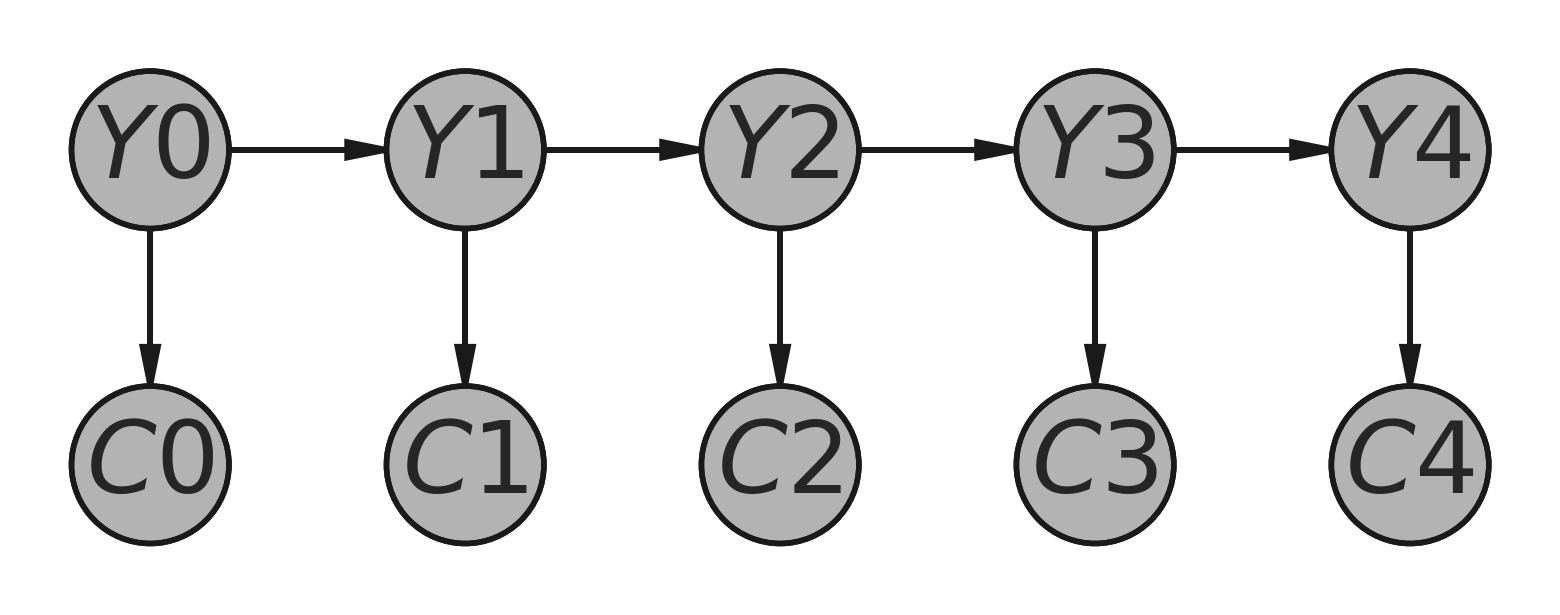

In [75]:
dbn = BayesianNetwork()
dbn.add_edges_from([('Y0', 'Y1'), 
                    ('Y1', 'Y2'), 
                    ('Y2', 'Y3'), 
                    ('Y3', 'Y4'), 
                    ('Y0', 'C0'),
                    ('Y1', 'C1'),
                    ('Y2', 'C2'),
                    ('Y3', 'C3'),
                    ('Y4', 'C4'),
                   ])
dbn.fit(df)
model_daft = dbn.to_daft(node_pos = {'Y0': [0,1],'Y1': [1,1],'Y2': [2,1],'Y3': [3,1],'Y4': [4,1],
                                     'C0': [0,0],'C1': [1,0],'C2': [2,0],'C3': [3,0],'C4': [4,0]},)
# To open the plot
model_daft.render(dpi = 400)

sts[0] = structure_score(dbn, df)

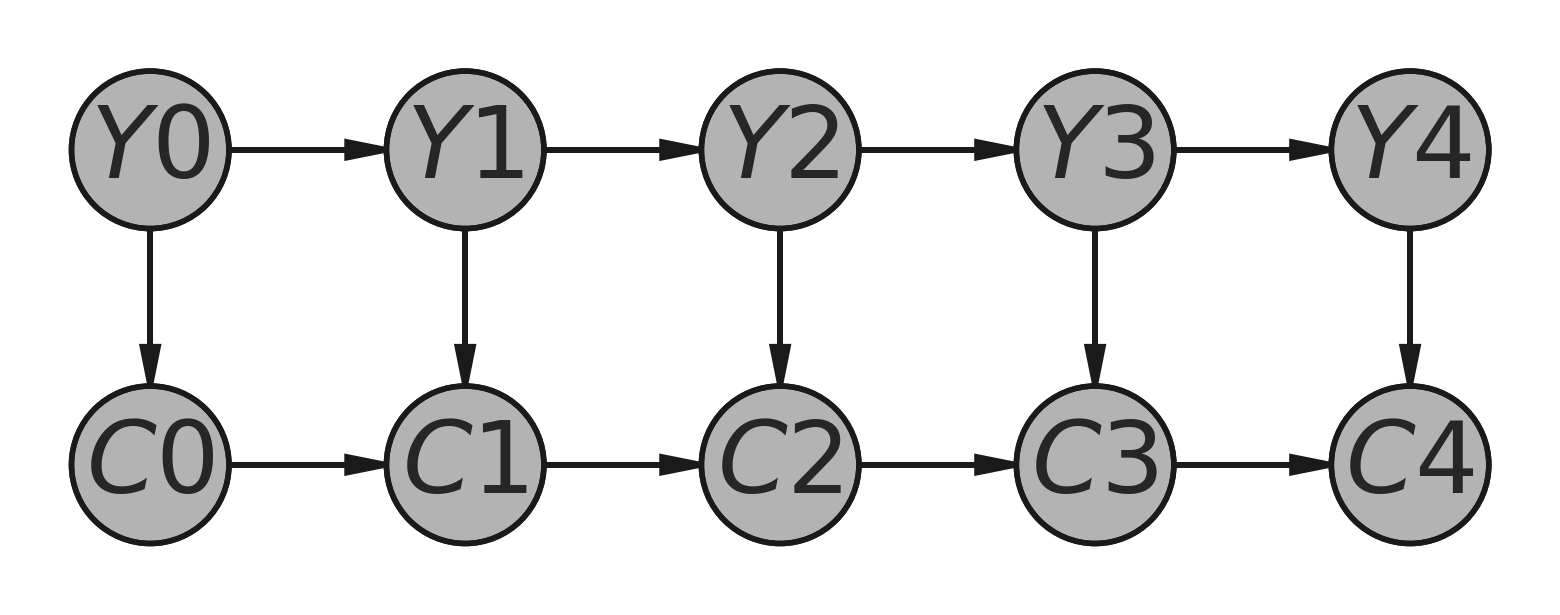

In [76]:
dbn = BayesianNetwork()
dbn.add_edges_from([('Y0', 'Y1'), 
                    ('Y1', 'Y2'), 
                    ('Y2', 'Y3'),
                    ('Y3', 'Y4'), 
                    ('Y0', 'C0'),
                    ('C0', 'C1'),
                    ('Y1', 'C1'),
                    ('C1', 'C2'),
                    ('Y2', 'C2'),
                    ('C2', 'C3'),
                    ('Y3', 'C3'),
                    ('C3', 'C4'),
                    ('Y4', 'C4'),
                   ])
dbn.fit(df)
model_daft = dbn.to_daft(node_pos = {'Y0': [0,1],'Y1': [1,1],'Y2': [2,1],'Y3': [3,1],'Y4': [4,1],
                                     'C0': [0,0],'C1': [1,0],'C2': [2,0],'C3': [3,0],'C4': [4,0]},)
# To open the plot
model_daft.render(dpi = 400)

sts[1] = structure_score(dbn, df)

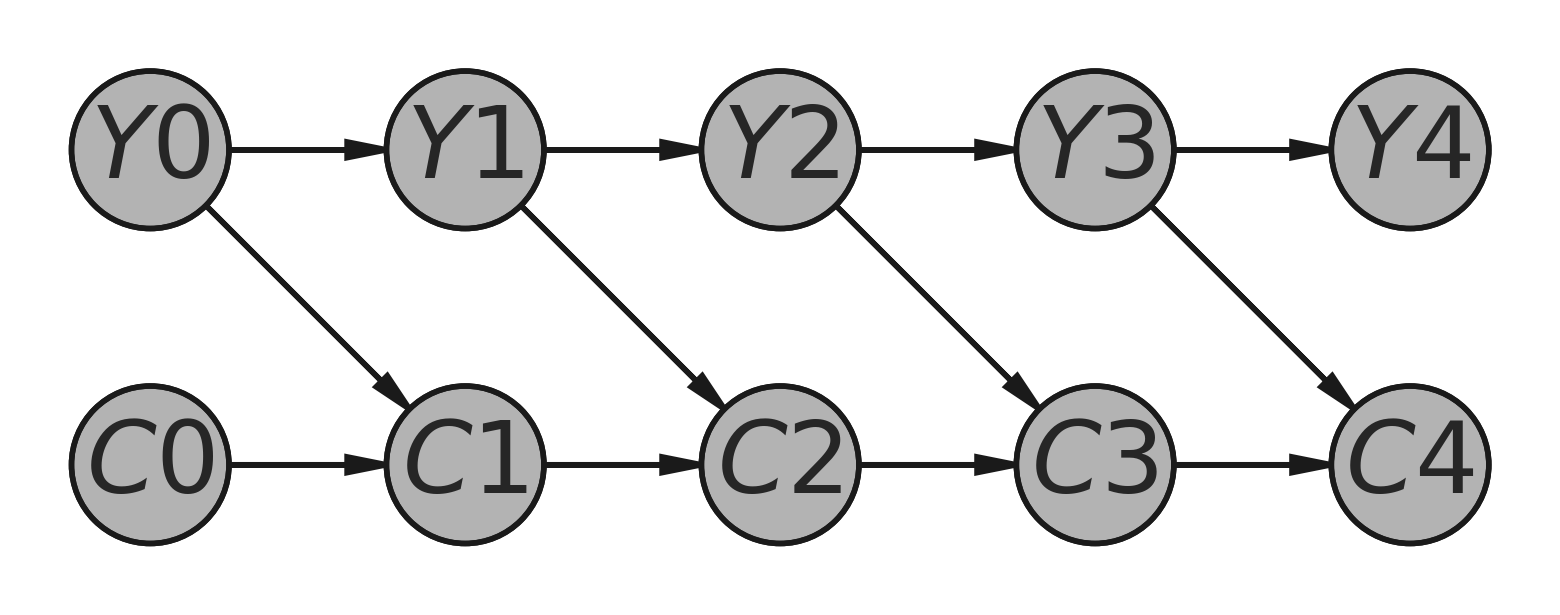

In [77]:
dbn = BayesianNetwork()
dbn.add_edges_from([('Y0', 'Y1'), 
                    ('Y1', 'Y2'), 
                    ('Y2', 'Y3'), 
                    ('Y3', 'Y4'), 
                    ('Y0', 'C1'),
                    ('C0', 'C1'),
                    ('Y1', 'C2'),
                    ('C1', 'C2'),
                    ('Y2', 'C3'),
                    ('C2', 'C3'),
                    ('Y3', 'C4'),
                    ('C3', 'C4'),
                   ])
dbn.fit(df)
model_daft = dbn.to_daft(node_pos = {'Y0': [0,1],'Y1': [1,1],'Y2': [2,1],'Y3': [3,1],'Y4': [4,1],
                                     'C0': [0,0],'C1': [1,0],'C2': [2,0],'C3': [3,0],'C4': [4,0]},)
# To open the plot
model_daft.render(dpi = 400)

sts[2] = structure_score(dbn, df)

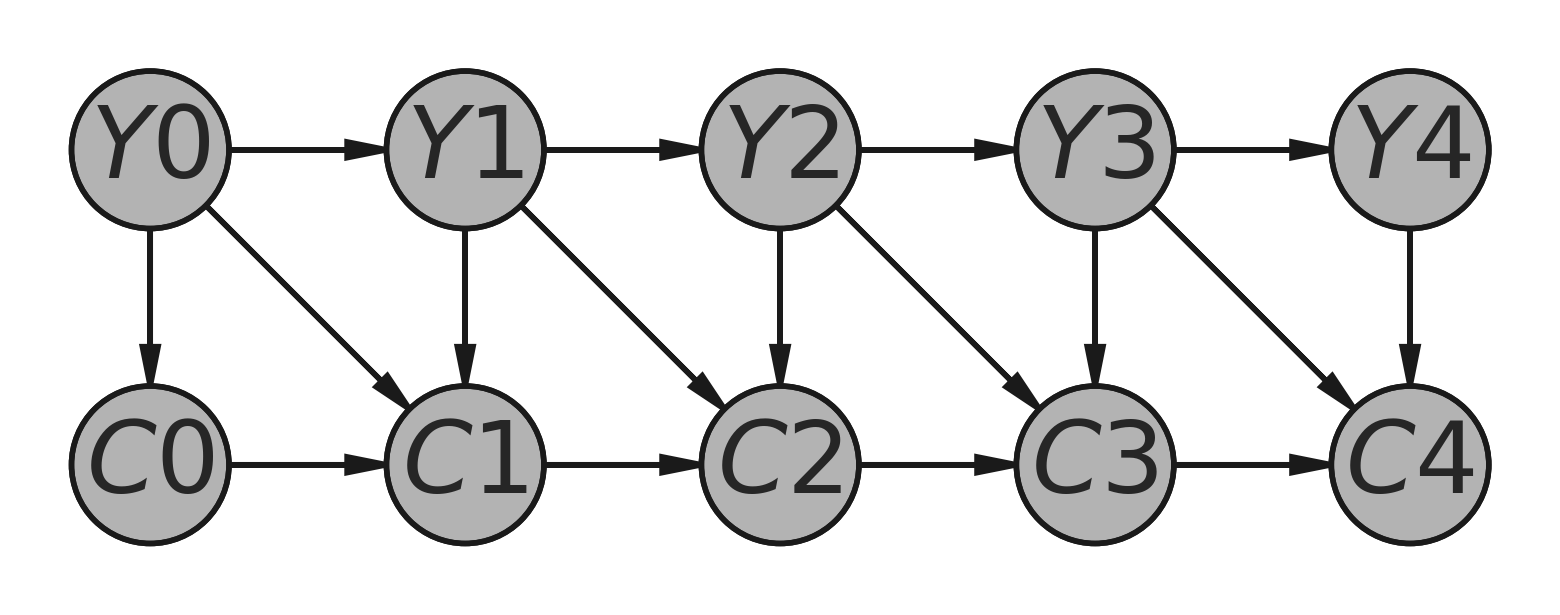

In [78]:
dbn = BayesianNetwork()
dbn.add_edges_from([('Y0', 'Y1'), 
                    ('Y1', 'Y2'), 
                    ('Y2', 'Y3'),
                    ('Y3', 'Y4'), 
                    ('Y0', 'C0'),
                    ('Y0', 'C1'),
                    ('C0', 'C1'),
                    ('Y1', 'C1'),
                    ('Y1', 'C2'),
                    ('C1', 'C2'),
                    ('Y2', 'C2'),
                    ('Y2', 'C3'),
                    ('C2', 'C3'),
                    ('Y3', 'C3'),
                    ('Y3', 'C4'),
                    ('C3', 'C4'),
                    ('Y4', 'C4'),
                   ])
dbn.fit(df)
model_daft = dbn.to_daft(node_pos = {'Y0': [0,1],'Y1': [1,1],'Y2': [2,1],'Y3': [3,1],'Y4': [4,1],
                                     'C0': [0,0],'C1': [1,0],'C2': [2,0],'C3': [3,0],'C4': [4,0]},)
# To open the plot
model_daft.render(dpi = 400)

sts[3] = structure_score(dbn, df)

In [84]:
sts_YS = pd.read_csv('results/analysis/YS_model_sts.csv', index_col = [0])
stss = pd.concat([pd.Series(sts), sts_YS], axis = 1)
stss = pd.DataFrame(stss.values, columns = ['YC', 'YS'], index = ['M1', 'M2', 'M3', 'M4'])
#stss.index.names = ['Model']
stss.columns.names = ['Vars']
#pd.MultiIndex.from_arrays([['YC', 'YS'],['BIC', 'BIC']])
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: white; color: black;'
}
s = stss.style
s = style_table(s, props, precision = True, transparency = False)
def style_negative(v, props=''):
    return props if v  else None
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')
s.apply(highlight_max, props='color:red', axis=0)#;background-color:darkblue'

s
# plt.savefig('figures_for_YSC_Bayesian_paper/S3A.png')
# plt.savefig('figures_for_YSC_Bayesian_paper/S3A.svg')

# Winning network

-688.3048066886863

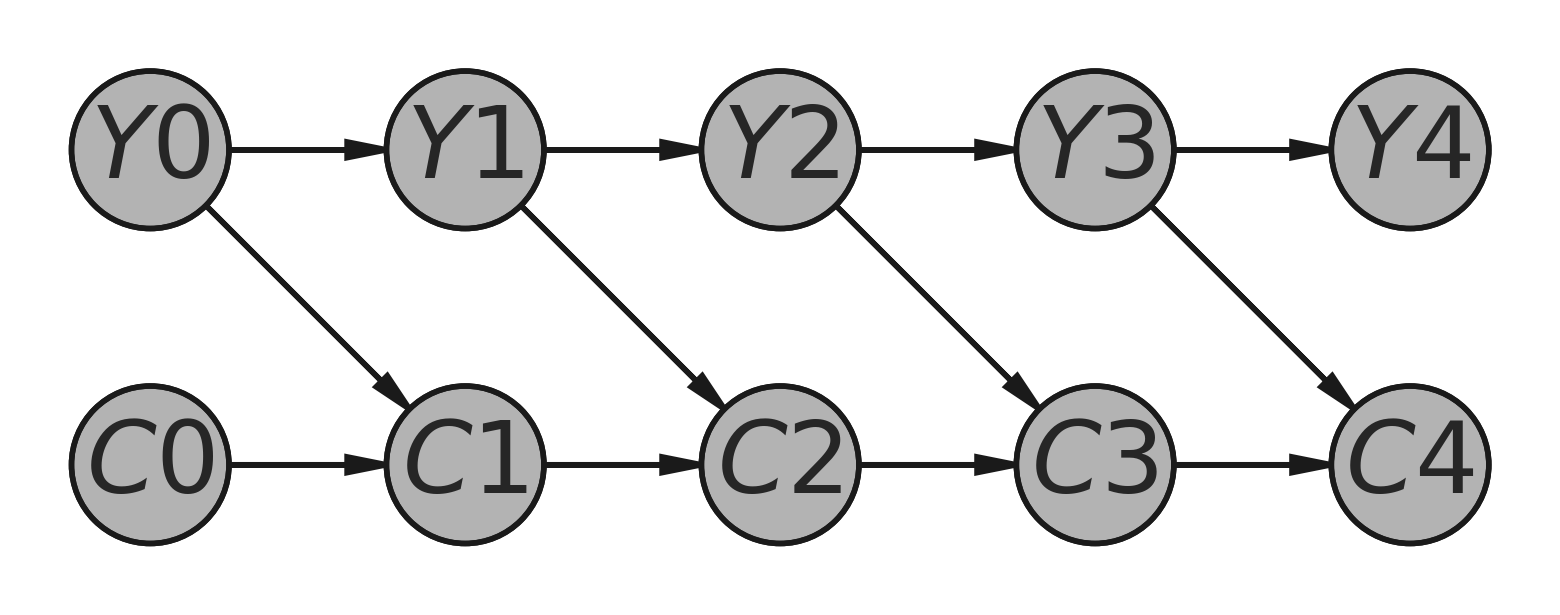

In [79]:
dbn = BayesianNetwork()
win_edg = [('Y0', 'Y1'), 
                    ('Y1', 'Y2'), 
                    ('Y2', 'Y3'), 
                    ('Y3', 'Y4'), 
                    ('Y0', 'C1'),
                    ('C0', 'C1'),
                    ('Y1', 'C2'),
                    ('C1', 'C2'),
                    ('Y2', 'C3'),
                    ('C2', 'C3'),
                    ('Y3', 'C4'),
                    ('C3', 'C4'),
                   ]
dbn.add_edges_from(win_edg)
dbn.fit(df)
model_daft = dbn.to_daft(node_pos = {'Y0': [0,1],'Y1': [1,1],'Y2': [2,1],'Y3': [3,1],'Y4': [4,1],
                                     'C0': [0,0],'C1': [1,0],'C2': [2,0],'C3': [3,0],'C4': [4,0]},)
# To open the plot
model_daft.render(dpi = 400)

structure_score(dbn, df)

## Simulate dynamics

In [80]:
cc = ['C'+str(i) for i in range(5)]
yy = ['Y'+str(i) for i in range(5)]
ss = ['S'+str(i) for i in range(5)]

In [81]:
n_embryos = 3000

### At the embryo level

In [ ]:
# import time
# t0 = time.time()
# from joblib import Parallel, delayed
# boot_embs = Parallel(n_jobs=100)(delayed(simulate_once)(df) for i in range(n_embryos))
# t1 = time.time()
# print(t1-t0)

In [ ]:
# # save
# import pickle
# f = open('results/analysis/bootstrapped_YC_embryos.p', 'wb')
# pickle.dump(boot_embs, f)
# f.close()

In [200]:
# save
import pickle
f = open('results/analysis/bootstrapped_YC_embryos.p', 'rb')
boot_embs = pickle.load(f)
f.close()

In [612]:
embs = {}

for i in range(n_embryos):
    embs[i] = concatenate_embryo(boot_embs[i])

In [613]:
props = {}
for i in range(n_embryos):
    props[i] = pd.Series([map_to_fc(tuple(x)) for x in embs[i][cc].values]).value_counts(normalize = True)
ap = pd.concat(props, axis = 1).fillna(0)

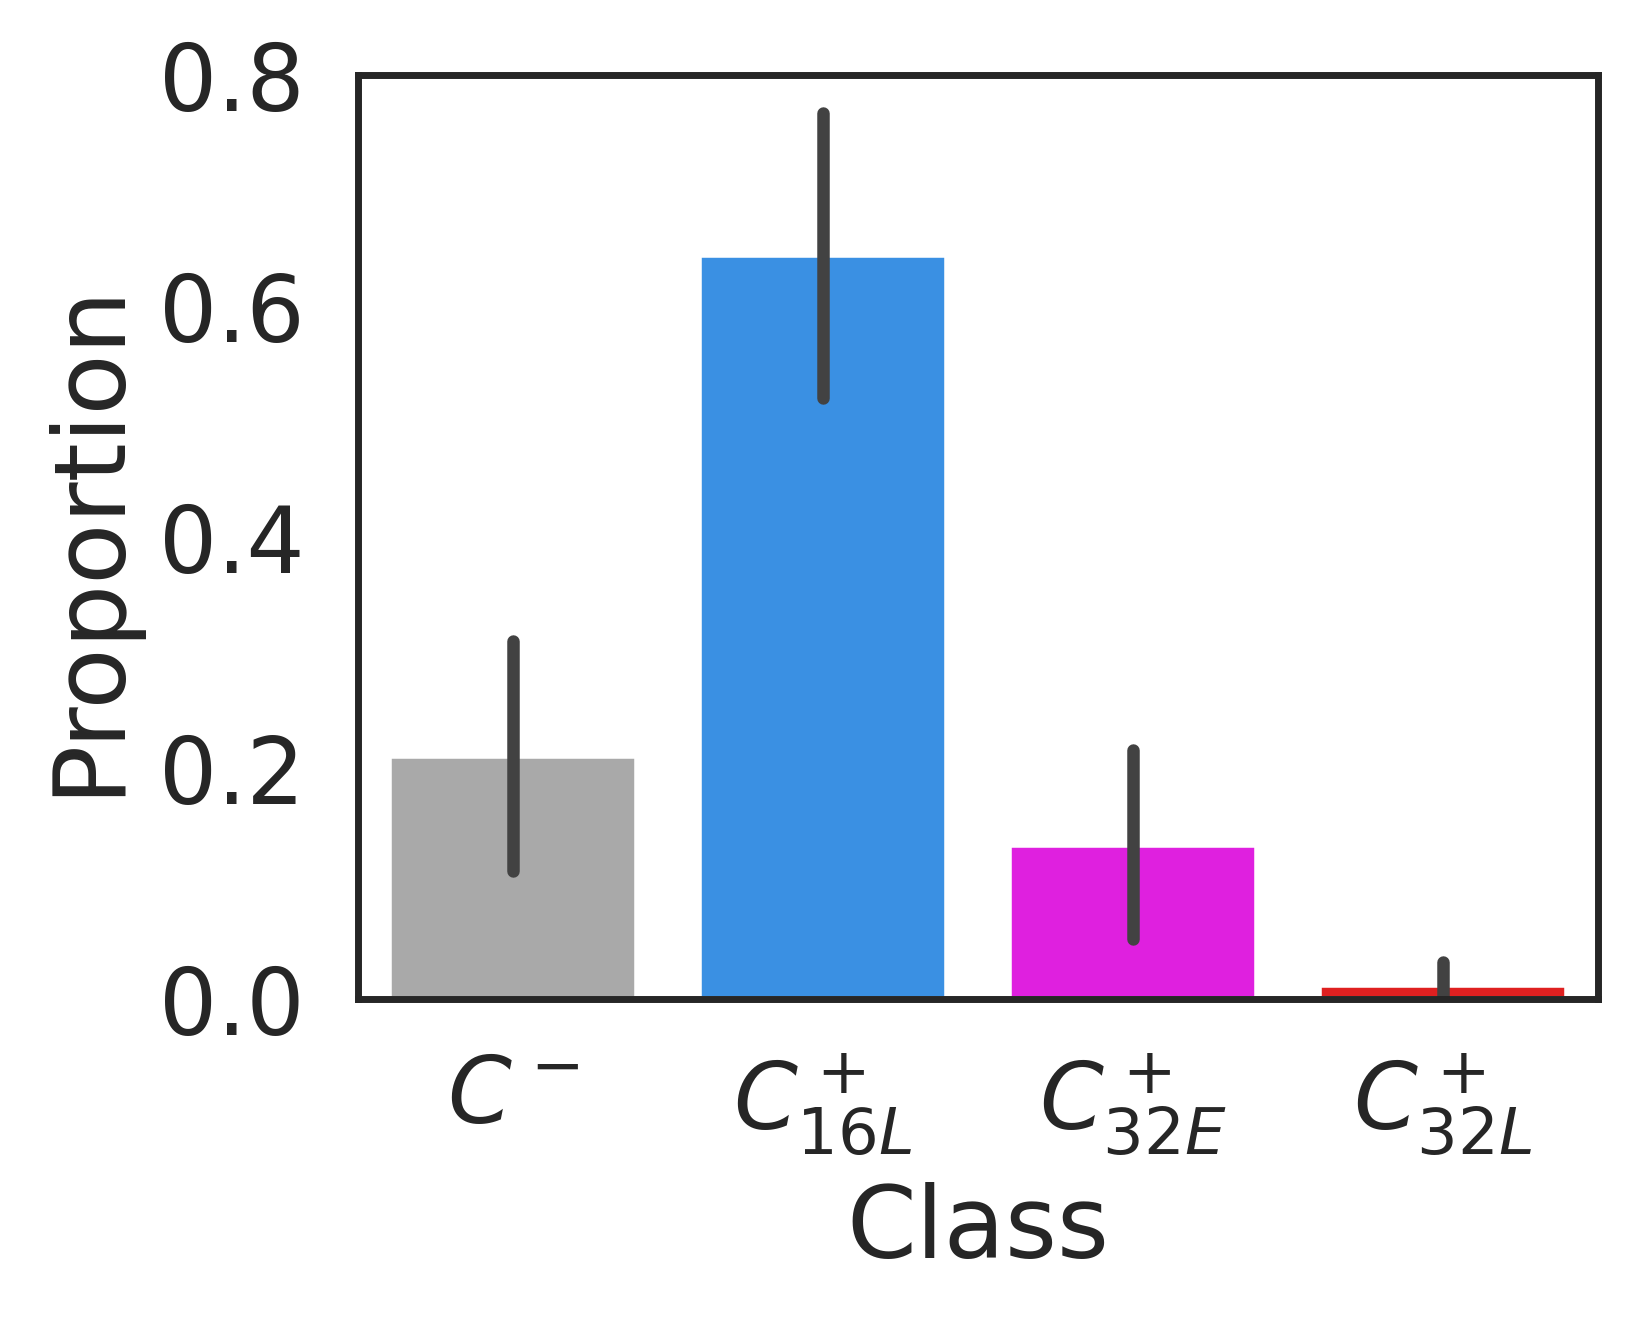

In [615]:
plt.figure(figsize = (4,3), dpi = 400)
all_props = ap.stack().reset_index()
all_props.columns = ['Class', 'Embryo', 'Proportion']
sns.barplot(all_props, x = 'Class', y = 'Proportion', hue = 'Class',
            order = [ '$C^-$','$C^+_{16L}$','$C^+_{32E}$', '$C^+_{32L}$',],
           hue_order = [ '$C^-$','$C^+_{16L}$','$C^+_{32L}$','$C^+_{32E}$'],
                 palette = ['darkgray','dodgerblue','red',  'magenta'],
            errorbar=('sd', 1)
           )#.T.plot.bar()
plt.ylim(0, 0.8)

plt.savefig('figures_for_YSC_Bayesian_paper/S3B.png')
plt.savefig('figures_for_YSC_Bayesian_paper/S3B.svg')

In [565]:
ap.mean(1), ap.std(1)

($C^+_{16L}$    0.643854
 $C^-$          0.210427
 $C^+_{32E}$    0.133500
 $C^+_{32L}$    0.012219
 dtype: float64,
 $C^+_{16L}$    0.123205
 $C^-$          0.099740
 $C^+_{32E}$    0.081902
 $C^+_{32L}$    0.020081
 dtype: float64)

In [1229]:
0.123205-0.117135

0.006069999999999992

In [206]:
# 0.3172*32, 0.2176*32

In [621]:
# plt.figure(figsize = (10,3))
# for i in range(4):
#     plt.subplot(1,4,i+1)
#     sns.distplot(ap.iloc[i,:])

In [630]:
# ddf = (ap*32).iloc[:-1,:].T
# plot_triple(ddf)

In [85]:
dbn = BayesianNetwork()
dbn.add_edges_from(win_edg)
dbn.fit(df)

In [86]:
# import time
# t0 = time.time()
# from joblib import Parallel, delayed
# raw_embs = Parallel(n_jobs=100)(delayed(simulate_embryo)(dbn) for i in range(n_embryos))
# t1 = time.time()
# print(t1-t0)

In [87]:
# # save
# import pickle
# f = open('results/analysis/simulated_YC_embryos.p', 'wb')
# pickle.dump(raw_embs, f)
# f.close()

In [89]:
# save
import pickle
f = open('results/analysis/simulated_YC_embryos.p', 'rb')
raw_embs = pickle.load(f)
f.close()

In [90]:
embs = {}

for i in range(n_embryos):
    embs[i] = concatenate_embryo(raw_embs[i])

In [91]:
props = {}
for i in range(n_embryos):
    props[i] = pd.Series([map_to_fc(tuple(x)) for x in embs[i][cc].values]).value_counts(normalize = True)

In [92]:
ap = pd.concat(props, axis = 1).fillna(0)

(0.0, 0.8)

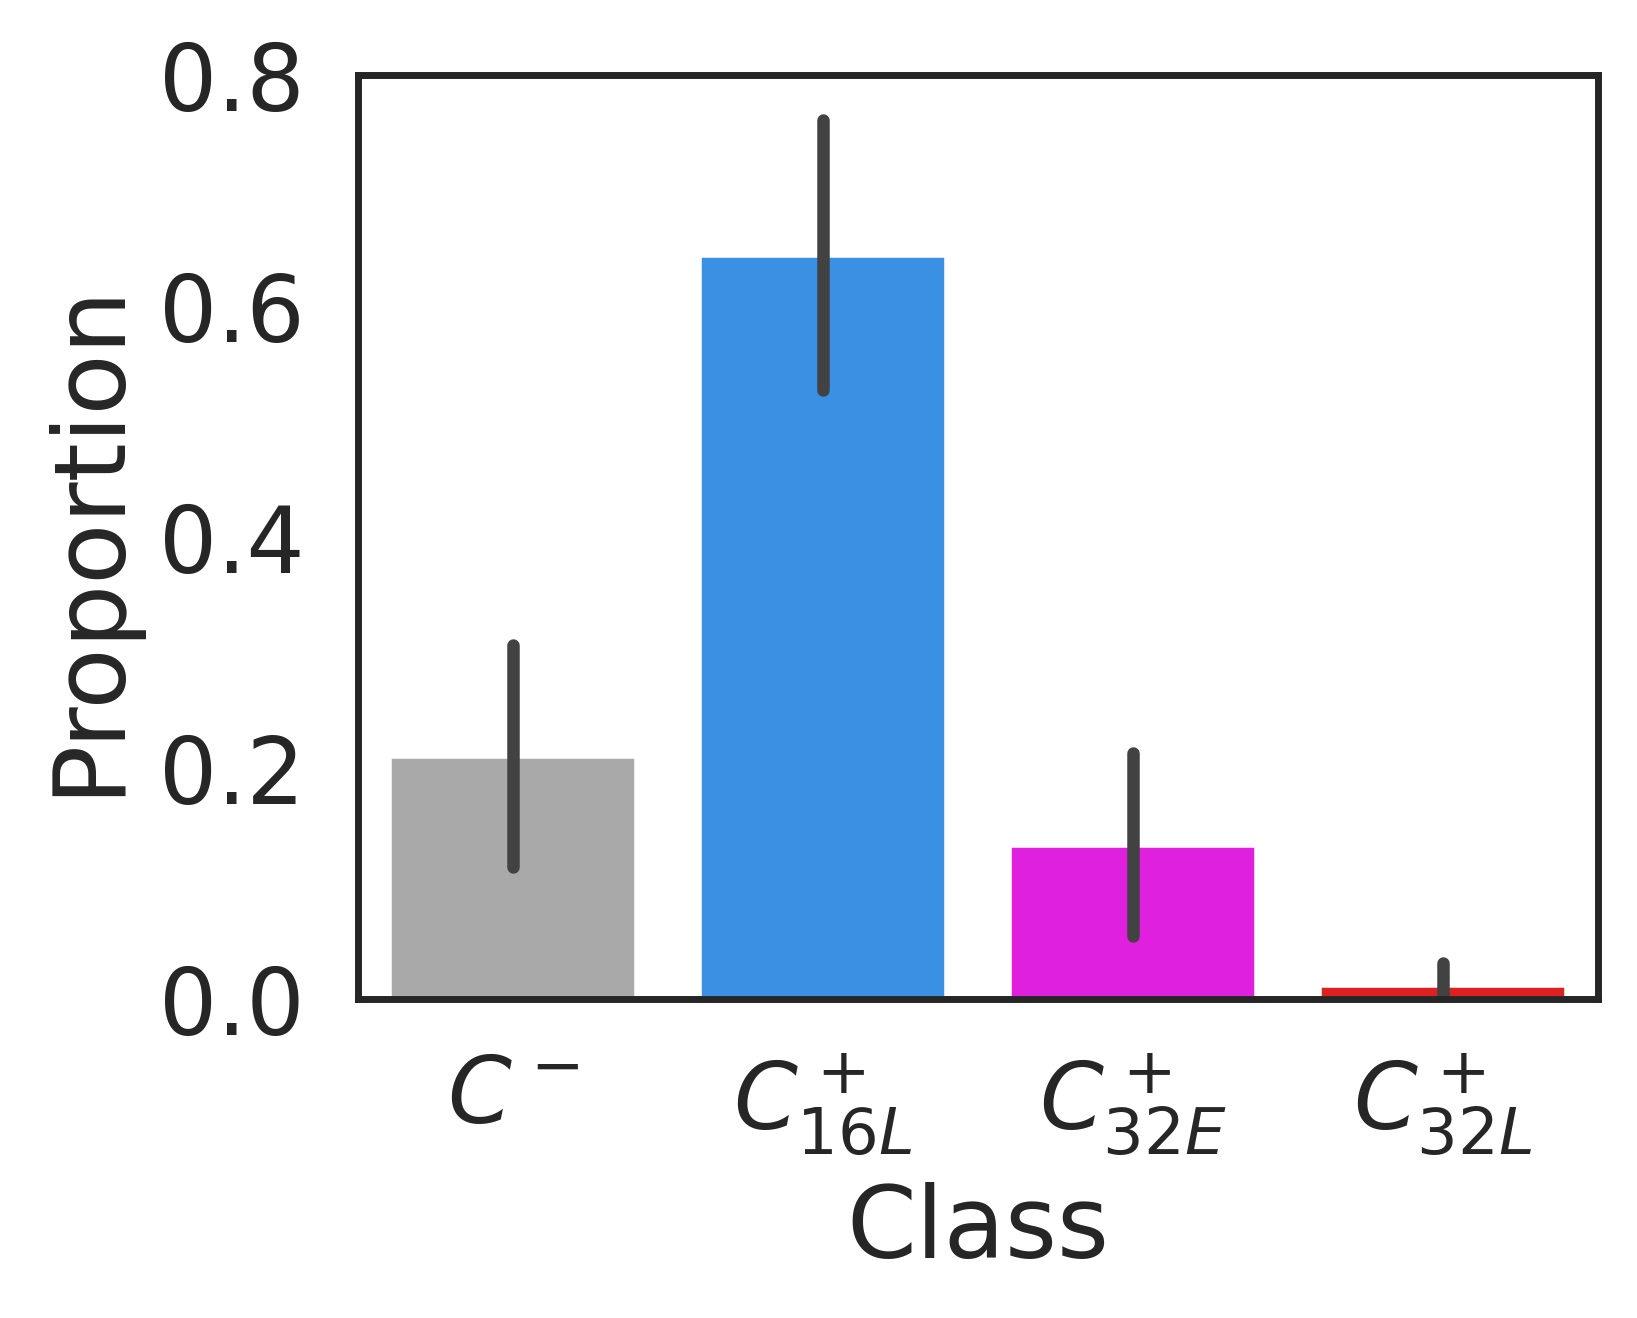

In [93]:
plt.figure(figsize = (4,3), dpi = 400)
all_props = ap.stack().reset_index()
all_props.columns = ['Class', 'Embryo', 'Proportion']
sns.barplot(all_props, x = 'Class', y = 'Proportion', hue = 'Class',
            order = [ '$C^-$','$C^+_{16L}$','$C^+_{32E}$', '$C^+_{32L}$',],
           hue_order = [ '$C^-$','$C^+_{16L}$','$C^+_{32L}$','$C^+_{32E}$'],
                 palette = ['darkgray','dodgerblue','red',  'magenta'],
            errorbar=('sd', 1)
           )#.T.plot.bar()
plt.ylim(0, 0.8)

# plt.savefig('figures_for_YSC_Bayesian_paper/3D.png')
# plt.savefig('figures_for_YSC_Bayesian_paper/3D.svg')

In [94]:
ap.mean(1), ap.std(1)

($C^+_{16L}$    0.644167
 $C^-$          0.210344
 $C^+_{32E}$    0.133625
 $C^+_{32L}$    0.011865
 dtype: float64,
 $C^+_{16L}$    0.117135
 $C^-$          0.096217
 $C^+_{32E}$    0.078900
 $C^+_{32L}$    0.019221
 dtype: float64)

## Variable elimination

In [95]:
dbn = BayesianNetwork()
dbn.add_edges_from(win_edg)
dbn.fit(df)

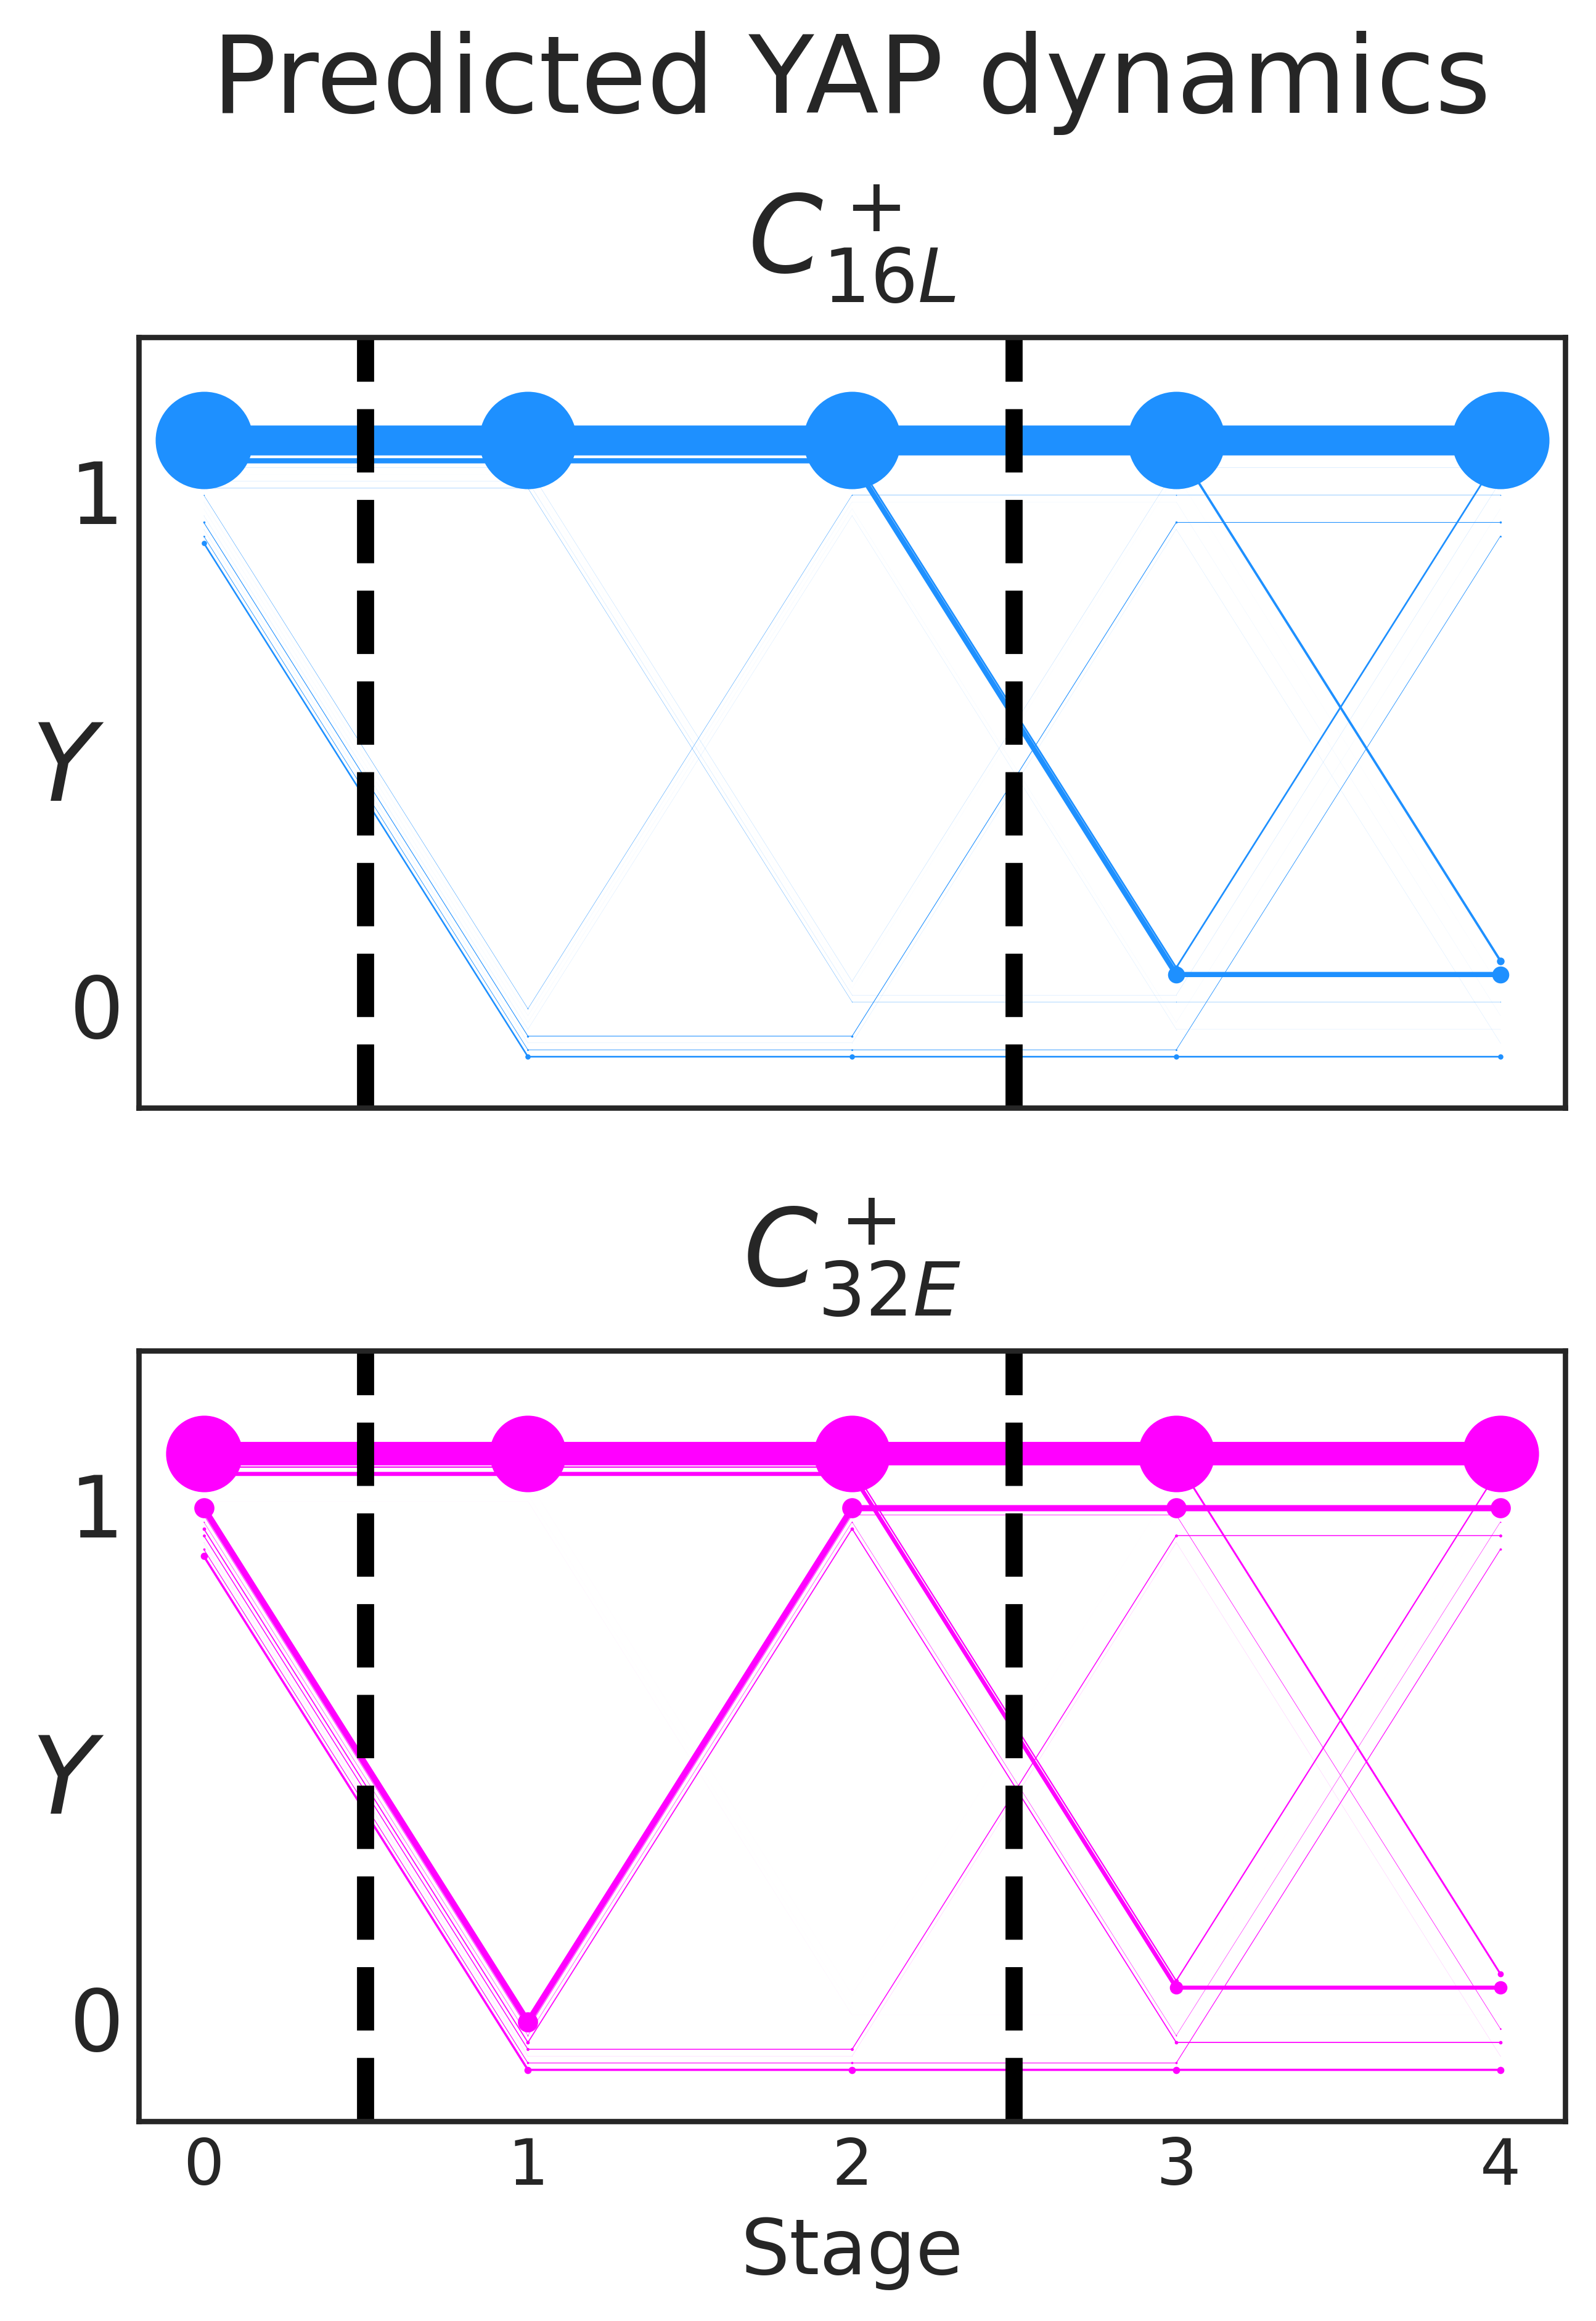

In [96]:
fig, axes = plt.subplots(2,1,figsize = (5.5,8), dpi = 500, sharex = True)

ax = axes[0]
ve = var_elim(dbn, 
         ['Y0', 'Y1', 'Y2', 'Y3', 'Y4'], 
         {'C2': 1})
plot_var_elim(ve, 
         lbl = 'Y', 
         title = '$C^+_{16L}$',#'$P(Y_{t=0\ldots 4}|C^+_{16L}, C^+)$',
        color = 'dodgerblue', figsize = (6,3), 
              ylim = (-0.2, 1.3), title_font = 25,
              dpi = 500, ax = ax, lw = 10, 
              lbl_y = 0.37)

ax = axes[1]
ve = var_elim(dbn, 
         ['Y0', 'Y1', 'Y2', 'Y3', 'Y4'], 
         {'C2': 0, 'C3': 1})
plot_var_elim(ve, 
         lbl = 'Y', 
         title = '$C^+_{32E}$',
        color = 'magenta', figsize = (6,3), 
              ylim = (-0.2, 1.3),title_font = 25,
              dpi = 500, ax = ax, lw = 10, lbl_y = 0.37)
plt.suptitle('Predicted YAP dynamics', y = 0.95, x = 0.53, fontsize = 25)
plt.tight_layout()
# plt.savefig('figures_for_YSC_Bayesian_paper/3E.png')
# plt.savefig('figures_for_YSC_Bayesian_paper/3E.svg')

In [97]:
ve = var_elim(dbn, 
         ['Y0', 'Y1', 'Y2', 'Y3', 'Y4'], 
         {'C2': 1})
# for figures
print(ve.loc[(1,1,1,1,1),:])

proportion    0.698643
Name: (1, 1, 1, 1, 1), dtype: float64


In [98]:
ve = var_elim(dbn, 
         ['Y0', 'Y1', 'Y2', 'Y3', 'Y4'], 
         {'C2': 0, 'C3': 1})
# for figures
print(ve.loc[(1,1,1,1,1),:]), print(ve.loc[(1,0,1,1,1),:]), print(ve.loc[(1,1,1,0,0),:])

proportion    0.549144
Name: (1, 1, 1, 1, 1), dtype: float64
proportion    0.144436
Name: (1, 0, 1, 1, 1), dtype: float64
proportion    0.095687
Name: (1, 1, 1, 0, 0), dtype: float64


(None, None, None)

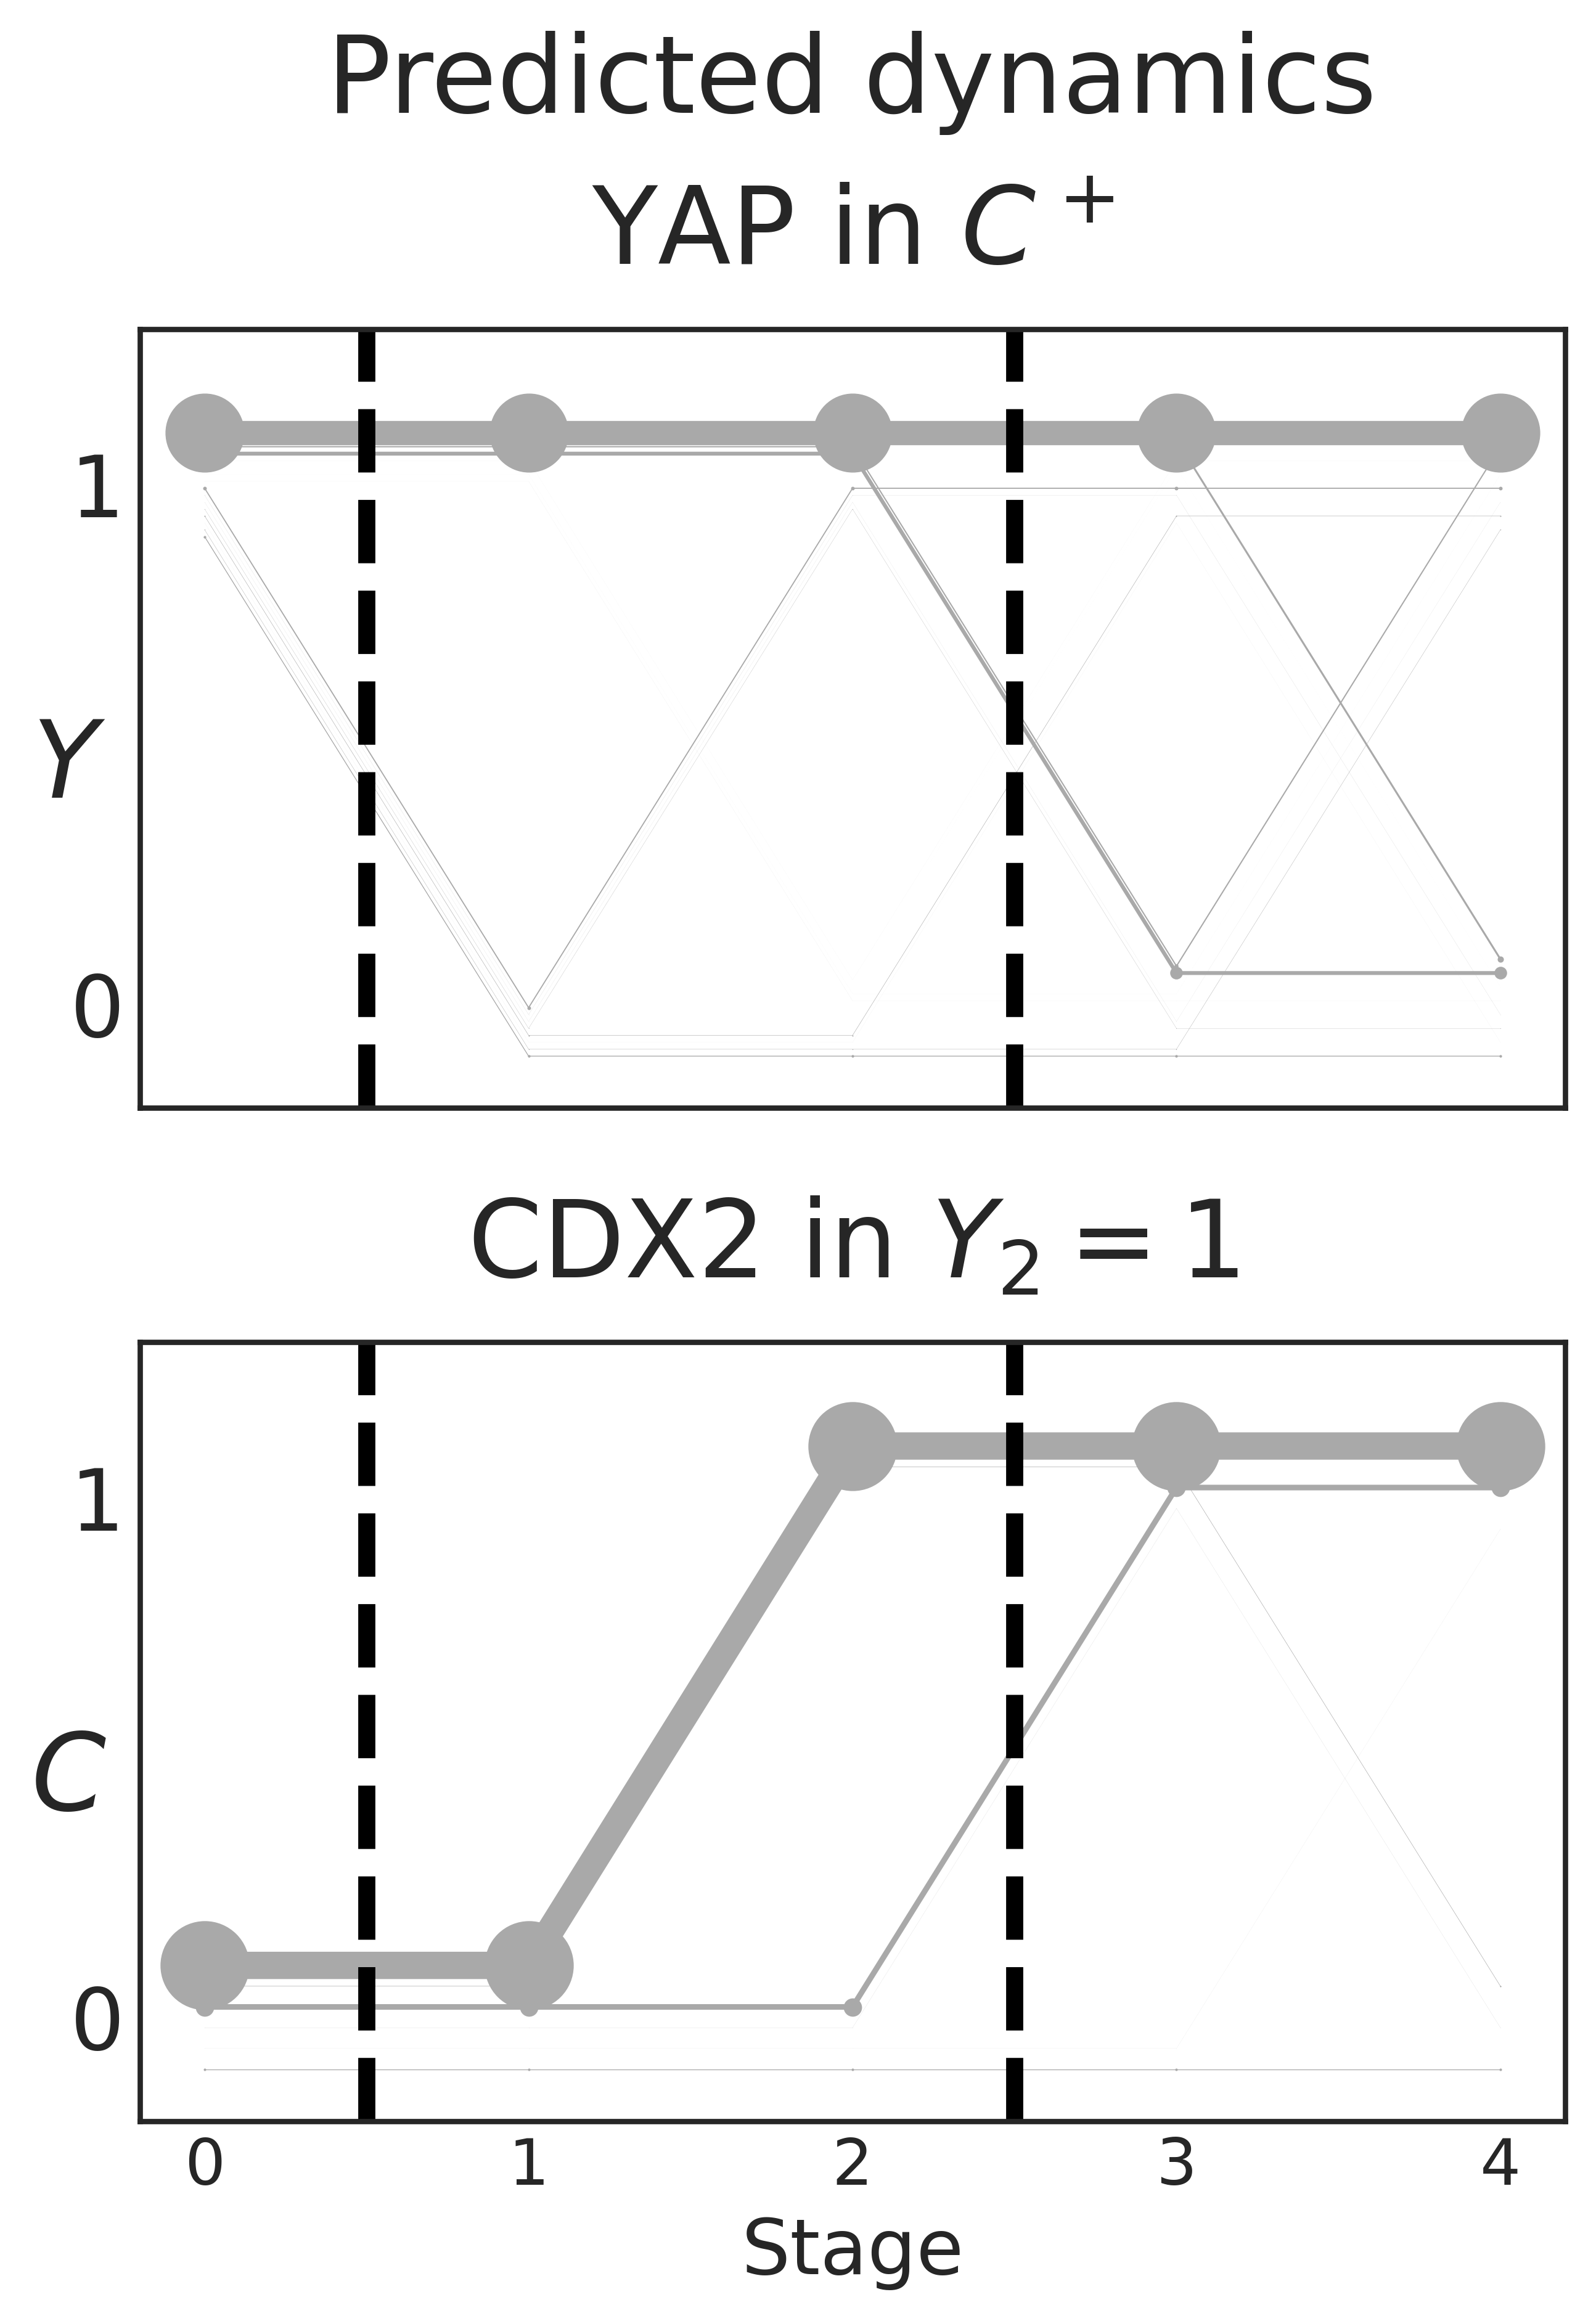

In [99]:
fig, axes = plt.subplots(2,1,figsize = (5.5,8), dpi = 500, sharex = True, sharey = False)

ax = axes[0]
ve = var_elim(dbn, 
         ['Y0', 'Y1', 'Y2', 'Y3', 'Y4'], 
         {'C4': 1})
plot_var_elim(ve, 
         lbl = 'Y', 
         title = 'YAP in $C^+$',#'$P(Y_{t=0\ldots 4}|C^+_{16L}, C^+)$',
        color = 'darkgray', figsize = (6,3), 
              ylim = (-0.2, 1.3), title_font = 25,
              dpi = 500, ax = ax, lw = 8, 
              lbl_y = 0.37)

ax = axes[1]
ve = var_elim(dbn, 
         ['C0', 'C1', 'C2', 'C3', 'C4'], 
         {'Y2': 1})
ve.index.names = yy
plot_var_elim(ve, 
         lbl = 'C', 
         title = 'CDX2 in $Y_2 = 1$',
        color = 'darkgray', figsize = (6,3), 
              ylim = (-0.2, 1.3),title_font = 25,
              dpi = 500, ax = ax, lw = 8, lbl_y = 0.37)

plt.suptitle('Predicted dynamics', y = 0.95, x = 0.53, fontsize = 25)
plt.tight_layout()
# plt.savefig('figures_for_YSC_Bayesian_paper/3F.png')
# plt.savefig('figures_for_YSC_Bayesian_paper/3F.svg')

In [100]:
ve = var_elim(dbn, 
         ['Y0', 'Y1', 'Y2', 'Y3', 'Y4'], 
         {'C4': 1})
# for figures
print(ve.loc[(1,1,1,1,1),:])
# for text
ve.groupby('Y2').sum()


proportion    0.708347
Name: (1, 1, 1, 1, 1), dtype: float64


proportion
Y2            
0     0.043772
1     0.956228

In [101]:
ve = var_elim(dbn, 
         ['C0', 'C1', 'C2', 'C3', 'C4'], 
         {'Y2': 1})
# for figures
print(ve.loc[(0,0,1,1,1),:]), print(ve.loc[(0,0,0,1,1),:])
# for text
#ve.groupby('Y2').sum()


proportion    0.797882
Name: (0, 0, 1, 1, 1), dtype: float64
proportion    0.164353
Name: (0, 0, 0, 1, 1), dtype: float64


(None, None)

# Add YS model

In [ ]:
YS_model = BayesianNetwork.load('results/analysis/YS_model_5_states.bif')

In [104]:
YS_data = pd.read_csv('results/analysis/data_for_YS_BN_5_states.csv', index_col = [0,1,2,3]).droplevel([1,2])

In [105]:
YC_data = df

In [106]:
YSC_data =  pd.concat([YS_data.reset_index(drop = True), YC_data.reset_index(drop = True)], axis = 0, keys = ['YS', 'YC'])

In [107]:
df_full = YSC_data

In [108]:
s_win_edg = [('Y0', 'Y1'), 
                    ('Y1', 'Y2'), 
                    ('Y2', 'Y3'), 
                    ('Y3', 'Y4'), 
                    ('Y0', 'S1'),
                    ('S0', 'S1'),
                    ('Y1', 'S2'),
                    ('S1', 'S2'),
                    ('Y2', 'S3'),
                    ('S2', 'S3'),
                    ('Y3', 'S4'),
                    ('S3', 'S4'),
                   ]

In [110]:
dbn = BayesianNetwork()
dbn.add_edges_from(win_edg)
dbn.add_edges_from(s_win_edg)
dbn.fit(df_full,
        estimator = MLE)
assert dbn.check_model()

<Axes: >

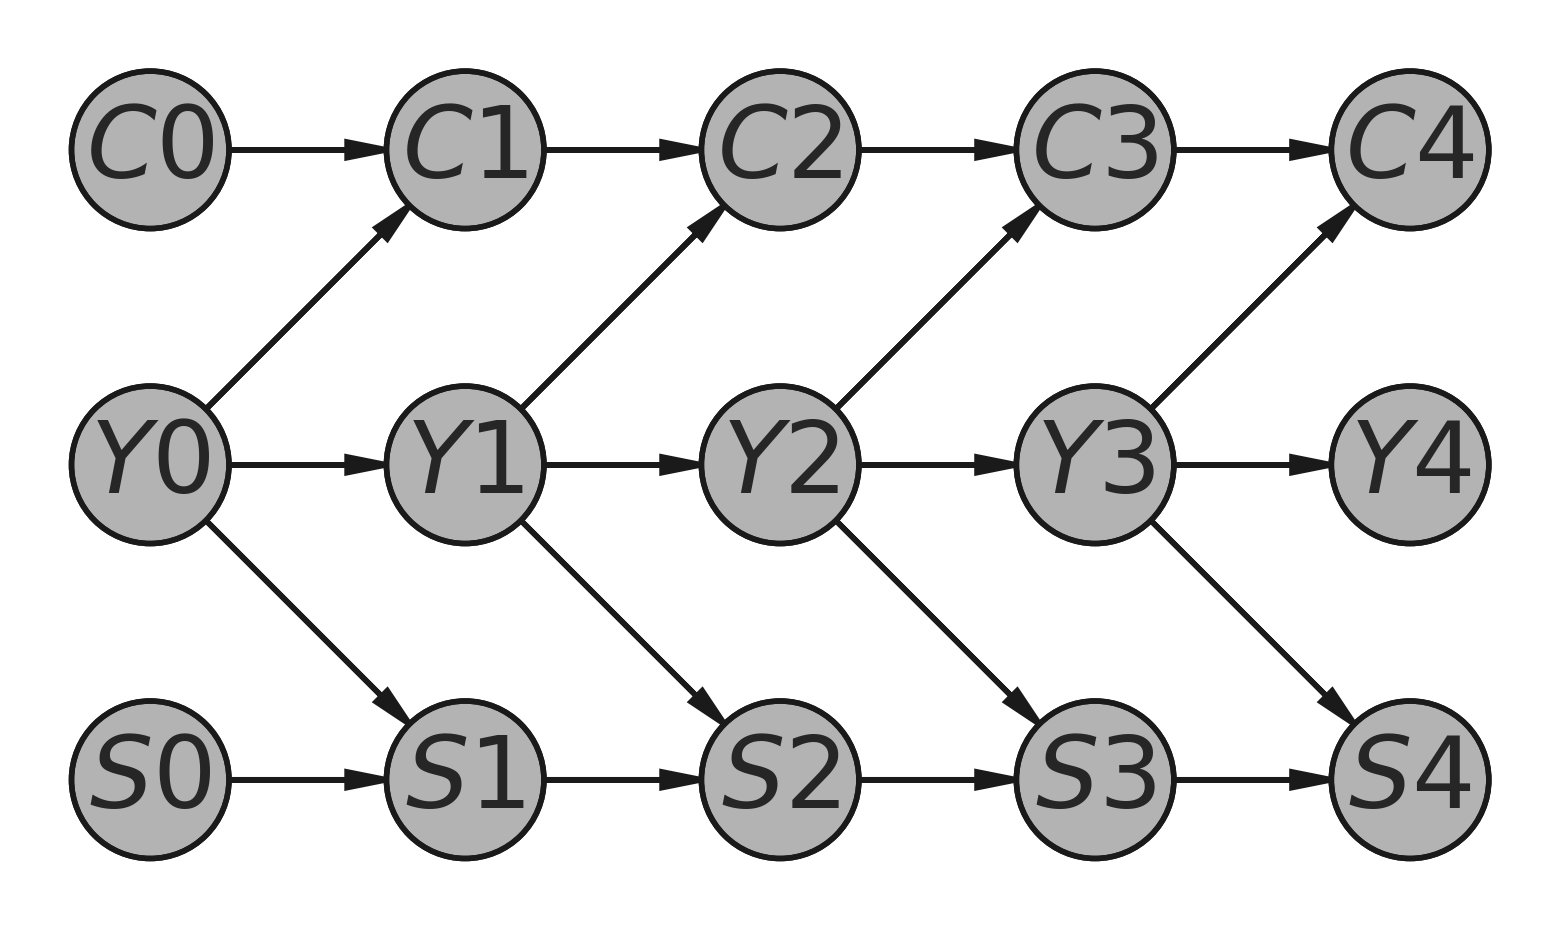

In [111]:
model_daft = dbn.to_daft(node_pos = {'C0': [0,1],'C1': [1,1],'C2': [2,1],'C3': [3,1],'C4': [4,1],
                                     'Y0': [0,0],'Y1': [1,0],'Y2': [2,0],'Y3': [3,0],'Y4': [4,0],
                                     'S0': [0,-1],'S1': [1,-1],'S2': [2,-1],'S3': [3,-1], 'S4': [4,-1]},
                       pgm_params={'observed_style': 'shaded'})
model_daft.render(dpi = 400)

In [112]:
# import time
# t0 = time.time()
# from joblib import Parallel, delayed
# raw_embs = Parallel(n_jobs=100)(delayed(simulate_embryo)(dbn, var_names = ['Y', 'S', 'C']) for i in range(n_embryos))
# t1 = time.time()
# print(t1-t0)

In [113]:
# # save
# import pickle
# f = open('results/analysis/simulated_YSC_embryos.p', 'wb')
# pickle.dump(raw_embs, f)
# f.close()

In [114]:
# save
import pickle
f = open('results/analysis/simulated_YSC_embryos.p', 'rb')
raw_embs = pickle.load(f)
f.close()

In [115]:
embs = {}

for i in range(n_embryos):
    embs[i] = concatenate_embryo(raw_embs[i])

## Map to classes

In [116]:
for i in range(n_embryos):
    embs[i]['C_class'] = [map_to_fc(tuple(x)) for x in embs[i][cc].values]
    embs[i]['S_class'] = [map_to_fs(tuple(x)) for x in embs[i][ss].values]

In [117]:
for i in range(n_embryos):
    embs[i]['Class'] = embs[i][['C4', 'S4']].astype(int).T.apply(map_to_class)
    embs[i]['Class_32E'] = embs[i][['C3', 'S3']].astype(int).T.apply(map_to_class)
    embs[i]['Class_16L'] = embs[i][['C2', 'S2']].astype(int).T.apply(map_to_class)
    embs[i]['Class_16E'] = embs[i][['C1', 'S1']].astype(int).T.apply(map_to_class)
    embs[i]['Class_8'] = embs[i][['C0', 'S0']].astype(int).T.apply(map_to_class)

In [118]:
def map_to_plus(x):
    if x == 1:
        return '+'
    else:
        return '-'
for i in range(n_embryos):
    embs[i]['C_final'] = embs[i]['C4'].astype(int).apply(map_to_plus)
    embs[i]['S_final'] = embs[i]['S4'].astype(int).apply(map_to_plus)

In [119]:
distribs = {}
for i in range(n_embryos):
    distribs[i] = embs[i][['Class']].value_counts(normalize = True)
distribs = pd.concat(distribs, axis = 1).fillna(0)
distribs_32L = distribs.copy()

In [120]:
distribs = {}
for i in range(n_embryos):
    distribs[i] = embs[i][['Class_32E']].value_counts(normalize = True)
distribs = pd.concat(distribs, axis = 1).fillna(0)
distribs_32E = distribs.copy()

In [121]:
distribs = {}
for i in range(n_embryos):
    distribs[i] = embs[i][['Class_16L']].value_counts(normalize = True)
distribs = pd.concat(distribs, axis = 1).fillna(0)
distribs_16L = distribs.copy()

Text(0, 0.5, 'cells')

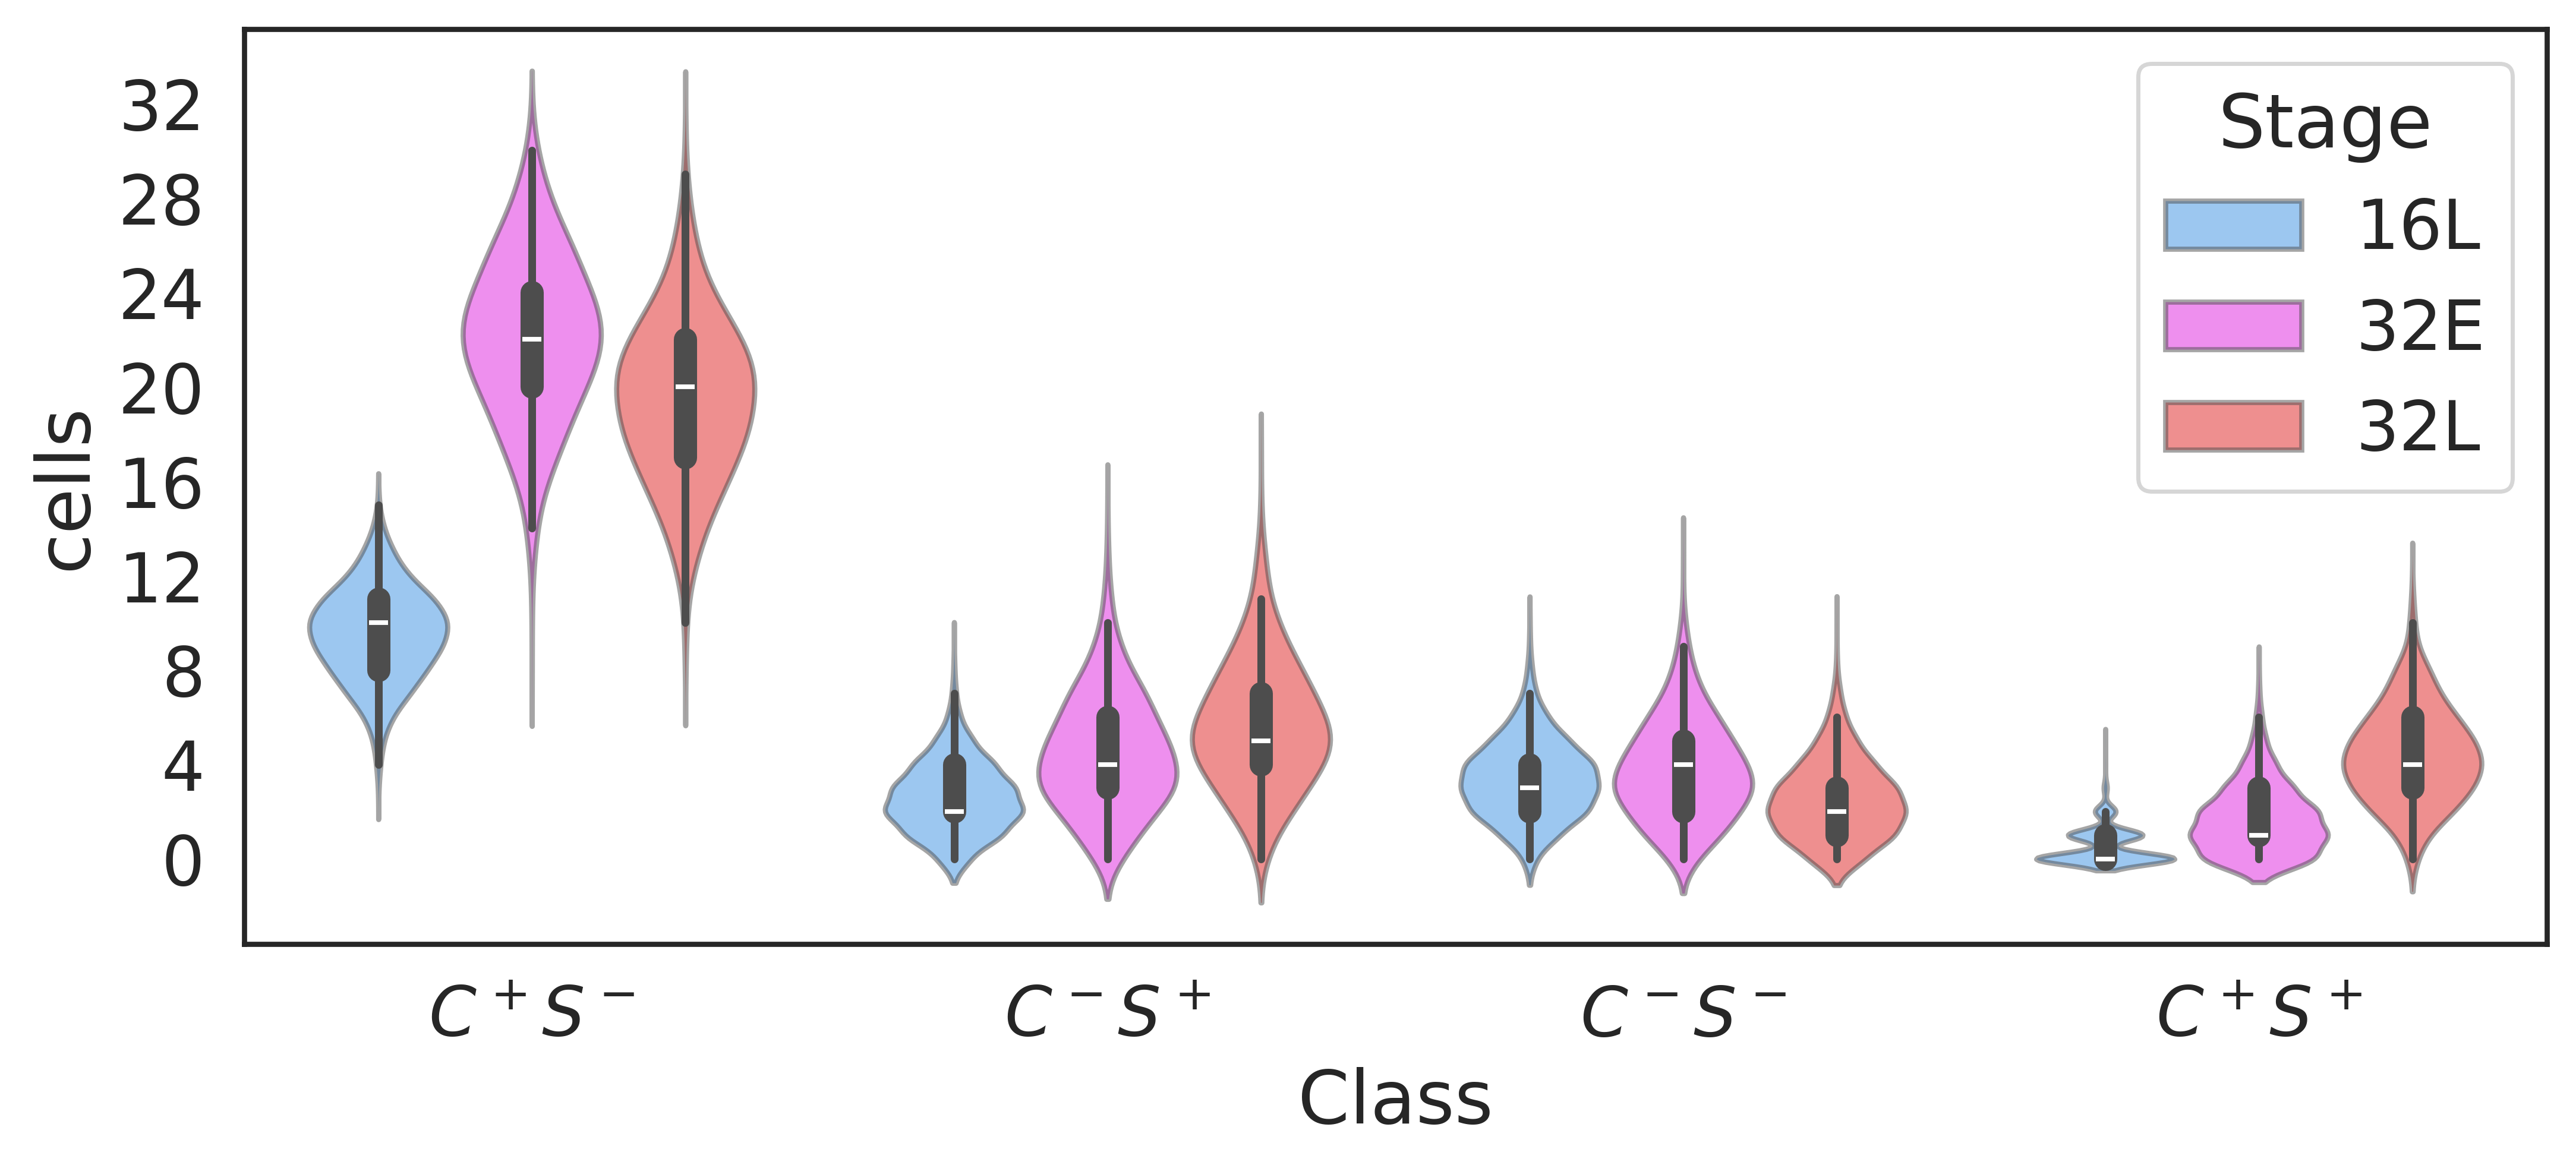

In [122]:
# over time
sns.set(font_scale = 1.5, style = 'white')
plt.figure(figsize = (10,4), dpi = 500)
over_time = pd.concat([distribs_16L*16, distribs_32E*32, distribs_32L*32], keys = ['16L', '32E', '32L'], axis = 0)
over_time = over_time.stack().reset_index()
over_time.columns = ['Stage', 'Class', 'Embryo', 'Proportion']
sns.violinplot(data = over_time, 
               hue = 'Stage', 
               x = 'Class', 
               order = ['$C^+S^-$', '$C^-S^+$', '$C^-S^-$', '$C^+S^+$'],
               split = False, 
               palette = ['dodgerblue', 'magenta', 'red'],#sns.color_palette('husl', 3)[::-1],
               bw_adjust = 1.7,density_norm = 'width',
               alpha = 0.5,
               width = 0.8, 
               gap = 0.1,
               y = 'Proportion')
plt.yticks(np.linspace(0,32,9).astype(int))
plt.ylabel('cells')
# plt.savefig('figures_for_YSC_Bayesian_paper/4D.png')
# plt.savefig('figures_for_YSC_Bayesian_paper/4D.svg')

In [123]:
distribs_32L.mean(1)*32, distribs_32L.std(1)*32

(Class   
 $C^+S^-$    19.462000
 $C^-S^-$     2.488667
 $C^+S^+$     4.396333
 $C^-S^+$     5.653000
 dtype: float64,
 Class   
 $C^+S^-$    3.428285
 $C^-S^-$    1.630979
 $C^+S^+$    2.018567
 $C^-S^+$    2.702288
 dtype: float64)

# Triple data

In [124]:

dbn = BayesianNetwork()
dbn.add_edges_from(win_edg)
dbn.add_edges_from(s_win_edg)
dbn.fit(df_full,
        estimator = MLE)
assert dbn.check_model()

In [125]:
yc_copy = df_full.loc['YC',:].copy()
ys_copy = df_full.loc['YS',:].copy()
yc_copy.index = data.index.droplevel([1,2])
ys_copy.index = YS_data.index

In [126]:
st = ['240120_stack_0', '240116_stack_2']
cc = ['C'+str(i) for i in range(5)]
ss = ['S'+str(i) for i in range(5)]
yy = ['Y'+str(i) for i in range(5)]
triple_data = pd.concat([yc_copy.loc[st][yy], yc_copy.loc[st][cc],ys_copy.loc[st][ss]], axis = 1)

In [128]:
true_dp = triple_data.query('C4 == 1 and S4 == 1').sort_values(yy)

In [129]:
true_dp_stack0 = [('240120_stack_0', '2_2'),
            ('240120_stack_0', '1_0'),
            ('240120_stack_0', '4_2')]
true_dp_stack2 = [('240116_stack_2', '1_1')]

proportion    0.328978
Name: (1, 1, 1, 0, 0), dtype: float64
proportion    0.600587
Name: (0.0, 0.0, 1.0, 1.0, 1), dtype: float64
proportion    0.5497
Name: (0.0, 0.0, 0.0, 0.0, 1), dtype: float64


Text(0.5, 1.05, 'Prediction for $C^+S^+$')

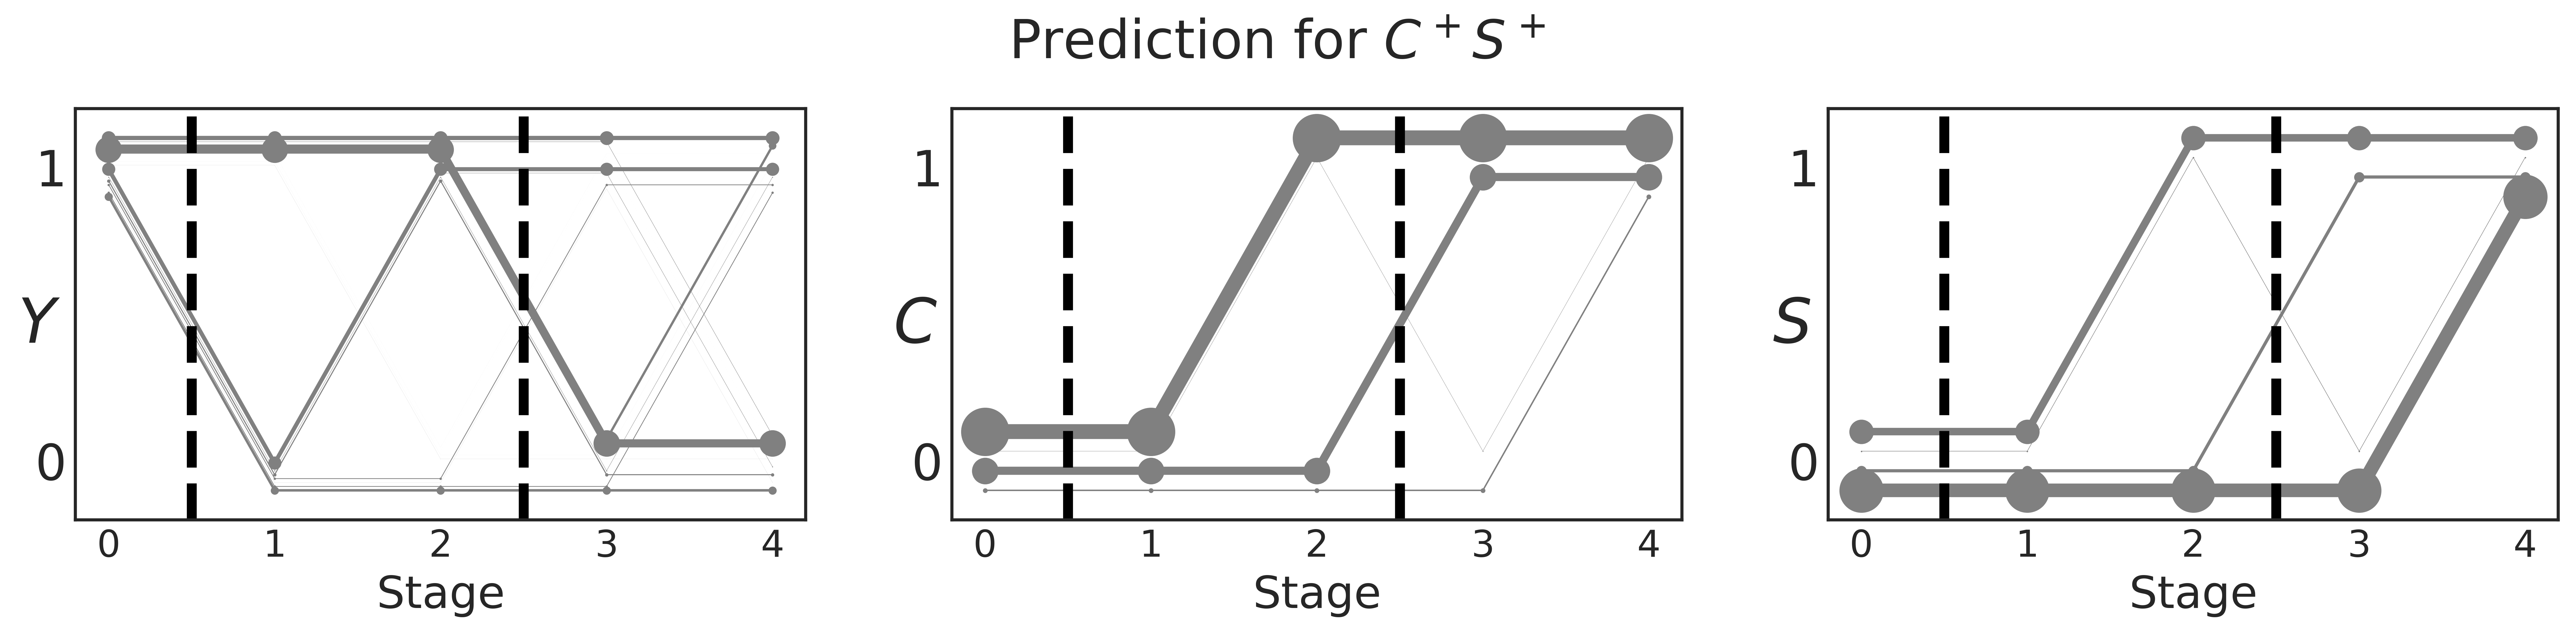

In [130]:
sns.set(palette = sns.color_palette('nipy_spectral',3), style = 'white', font_scale = 1.5)
fig, axes = plt.subplots(1,3,dpi = 600, figsize = (18,3), sharey = False)
ax = axes[0]
ve = var_elim(dbn, 
         yy, 
         {'C4': 1, 'S4':1})
plot_var_elim(ve, ax = ax,
         lbl = 'Y', 
         title = '',#$P(C_{t=0\ldots 4}|C^+S^+)$',
        color = 'grey')
print(ve.loc[(1,1,1,0,0),:])
ax = axes[1]
ve = var_elim(dbn, 
         ['C0', 'C1', 'C2', 'C3'], 
         {'C4':1, 'S4':1})
ve['C4'] = 1
ve.set_index('C4', append = True, inplace = True)
print(ve.loc[(0,0,1,1,1),:])
plot_var_elim(ve, ax = ax,
         lbl = 'C', 
         title = '',#$P(C_{t=0\ldots 4}|C^+S^+)$',
        color = 'grey')
ax = axes[2]
ve = var_elim(dbn, 
         ['S0', 'S1', 'S2', 'S3'], 
         {'C4': 1, 'S4':1})
ve['S4'] = 1
ve.set_index('S4', append = True, inplace = True)
print(ve.loc[(0,0,0,0,1),:])
plot_var_elim(ve, ax = ax,
         lbl = 'S', 
         title = '',#$P(C_{t=0\ldots 4}|C^+S^+)$',
        color = 'grey')

fig.suptitle('Prediction for $C^+S^+$', y = 1.05)

# fig.savefig('figures_for_YSC_Bayesian_paper/4D.png', dpi = 500)
# fig.savefig('figures_for_YSC_Bayesian_paper/4D.svg', dpi = 500)

Text(0.5, 1.05, 'True $C^+S^+$')

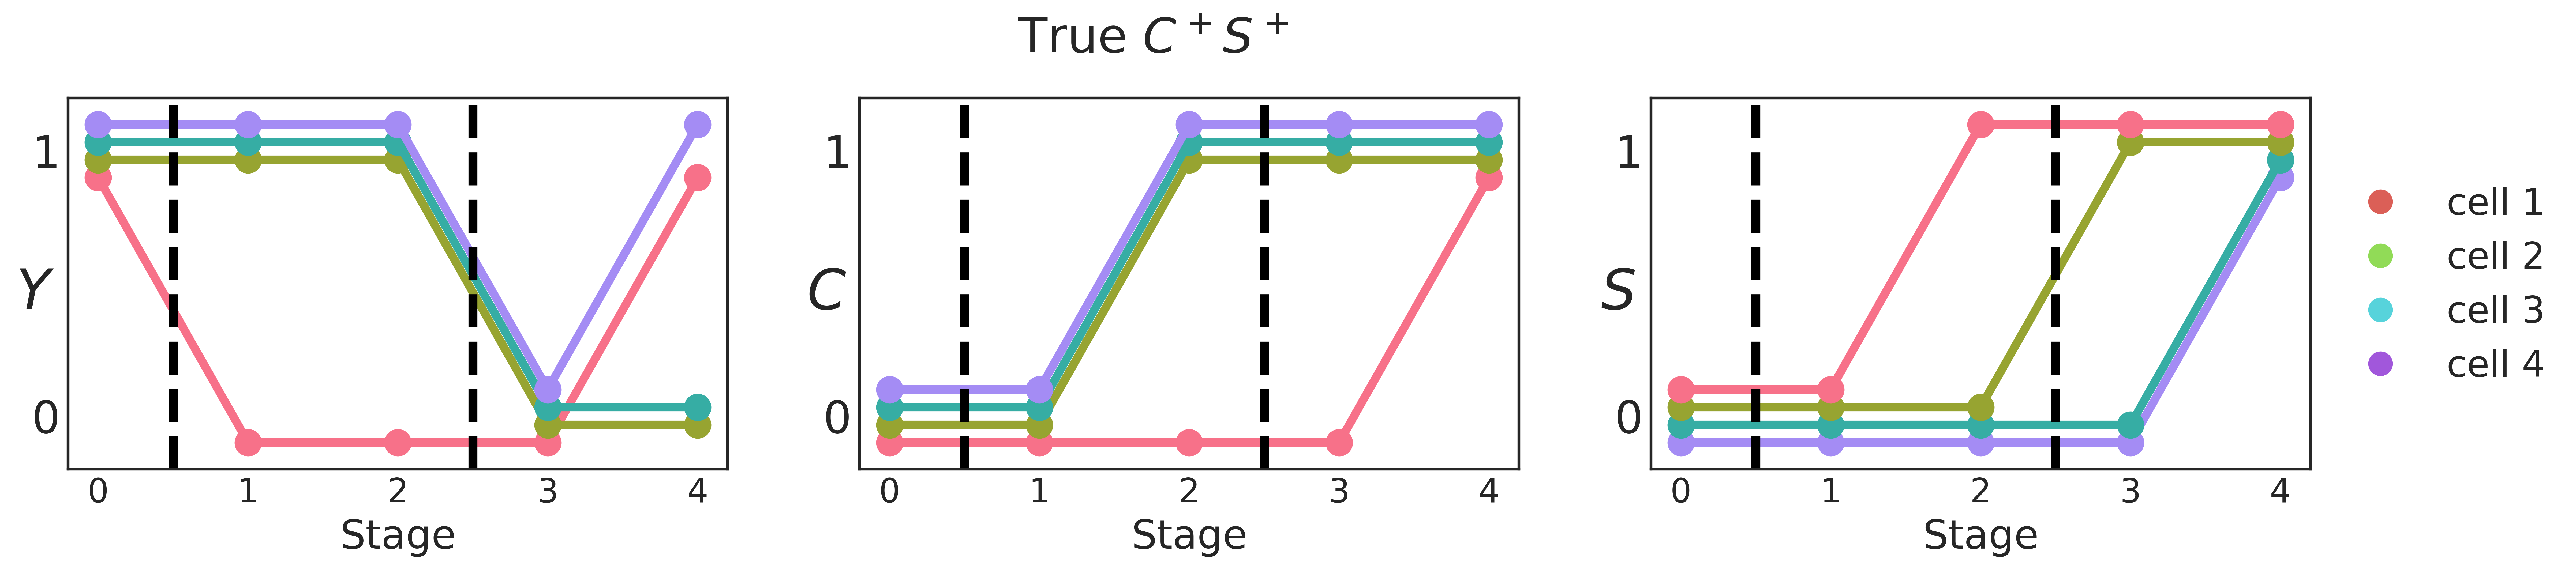

In [133]:
import matplotlib.lines as mlines

sns.set(palette = sns.color_palette('nipy_spectral',3), style = 'white', font_scale = 1.5)
fig, axes = plt.subplots(1,3,dpi = 600, figsize = (18,3), sharey = False)
n_cells = 4
ax = axes[0]
ve = pd.DataFrame([0.25]*n_cells, index = true_dp[yy].set_index(yy).index)
ve.columns = ['proportion']
plot_var_elim(ve, 
         lbl = 'Y', lw = 15,
         title = '',#$Y_{t=0\ldots 4}$, true $C^+S^+$',
        color = None, ax = ax, hue = 'Sequence', 
         palette = dict(zip(range(n_cells), sns.color_palette('husl',n_cells))))
ax = axes[1]
ve = pd.DataFrame([0.25]*4, index = true_dp[cc].set_index(cc).index)
ve.columns = ['proportion']
plot_var_elim(ve, 
         lbl = 'C', lw = 15,
         title = '',#$C_{t=0\ldots 4}$ true $C^+S^+$',
        color = None, ax = ax, hue = 'Sequence', 
         palette = dict(zip(range(n_cells), sns.color_palette('husl',n_cells))))
ax = axes[2]
ve = pd.DataFrame([0.25]*4, index = true_dp.iloc[::-1,:][ss].set_index(ss).index)
ve.columns = ['proportion']
plot_var_elim(ve, 
         lbl = 'S', lw = 15,
         title = '',#$S_{t=0\ldots 4}$, true $C^+S^+$',
         color = None, ax = ax, hue = 'Sequence', legend = True,
         palette = dict(zip(range(n_cells), sns.color_palette('husl',n_cells)[::-1])))
# labels, handles = ax.get_legend_handles_labels()
# ax.legend(handles = handles, labels = ['cell '+str(i) for i in range(1,5)])

handles = []
i=1
for col in  sns.color_palette('hls',n_cells):
    handles.append(mlines.Line2D([], [], color=col, marker='o', linestyle='None',
                          markersize=10, label='cell '+str(i)))
    i+=1
ax.legend(handles = handles, 
          labels = ['cell '+str(i) for i in range(1,5)],
          bbox_to_anchor = (1,0.85),
          frameon=False)
fig.suptitle('True $C^+S^+$', y = 1.05)
# fig.savefig('figures_for_YSC_Bayesian_paper/4F.png', dpi = 500)
# fig.savefig('figures_for_YSC_Bayesian_paper/4F.svg', dpi = 500)